In [4]:
using LinearAlgebra
using SparseArrays
using Random
using CairoMakie
using Statistics
using DynamicalSystemsBase
using ProgressMeter
using DataFrames
using StatsBase

In [5]:
# total_time = 300
# time_delta = 0.01
# ts_str = ["x", "y", "z"]
# init_conds = [-15.0,-15.0,10.0]
# lo_variables = [10, 8/3, 28]
# init_time_to_ignore = 10

total_time = 500
time_delta = 0.05
ts_str = ["x", "y", "z"]
init_conds = [-15.0,-15.0,10.0]
lo_variables = [10, 8/3, 28]
init_time_to_ignore = 10

10

In [6]:
function Lorenz(u, p, t)
    σ = p[1]
    β = p[2]
    ρ = p[3]

    du1 = σ*(u[2]-u[1])
    du2 = u[1]*(ρ-u[3]) - u[2]
    du3 = u[1]*u[2] - β*u[3]

    return SVector(du1, du2, du3)
end

Lorenz (generic function with 1 method)

In [7]:
lo = CoupledODEs(Lorenz, init_conds, lo_variables)
lo_tr, tvec = trajectory(lo, total_time; Δt = time_delta, Ttr = init_time_to_ignore)

(3-dimensional StateSpaceSet{Float64} with 10001 points, 10.0:0.05:510.0)

In [8]:
function SplitSet(set, ratio)
    split_point = trunc(Int, ratio*length(set))
    train_set = set[1:split_point]
    test_set = set[split_point+1:length(set)]
    
    return(train_set, test_set)
end

SplitSet (generic function with 1 method)

In [9]:
lo_train, lo_test = SplitSet(lo_tr[:,1], 0.8)

([5.126534053596909, 5.834707413699581, 6.991808357426451, 8.530218492050775, 10.224320148458034, 11.579262391541565, 11.948150768409606, 11.02325560795919, 9.2017949533067, 7.247977130696019  …  5.077681027821892, 3.0478176252011457, 1.9279701157144167, 1.437857386040465, 1.353230578626462, 1.5580404279676863, 2.033744024173971, 2.844270111435518, 4.130680100078396, 6.098330280510625], [8.922748372508533, 12.38960052200712, 15.193402641819919, 15.120150964731685, 11.69730215411192, 7.1630730712588315, 3.5237195165663295, 1.2226732082648095, -0.08865301351516021, -0.862771191380489  …  -8.078234078985824, -9.74934151620846, -11.246056374765327, -11.93797064120169, -11.372904735504541, -9.750263627364301, -7.78378266119449, -6.121317642617538, -5.0527320746766256, -4.600820630976283])

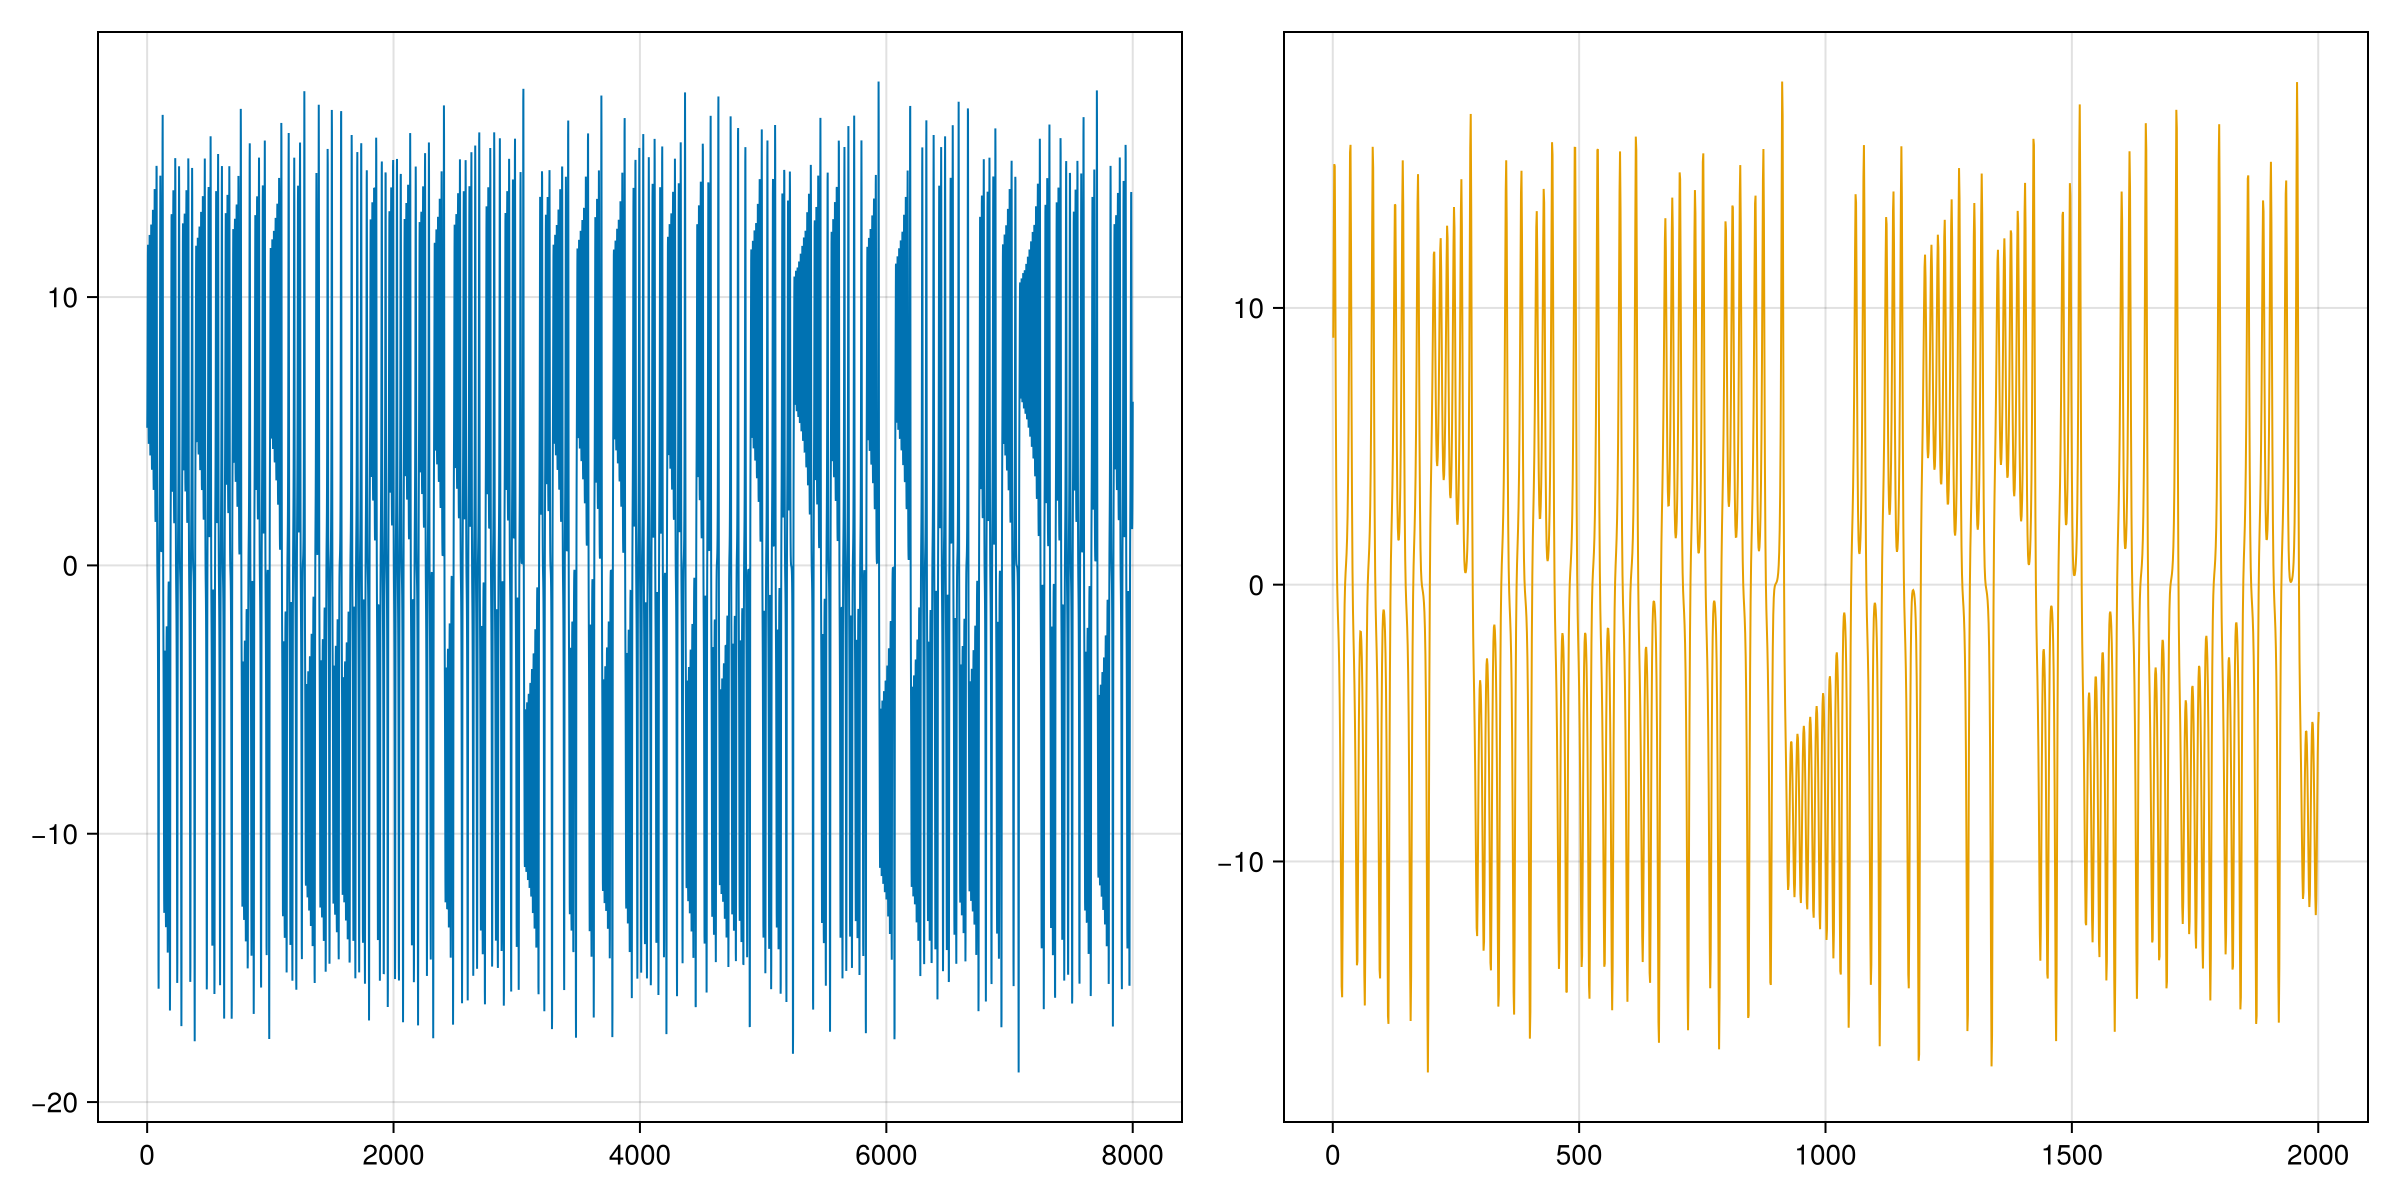

In [10]:
fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [11]:


# test_matrix = [
#     0.1  0.2  0.4  0.7  0.11 16
#     0.2  0.3  0.5  0.8  0.12 17
#     0.4  0.5  0.6  0.9  0.13 18
#     0.7  0.8  0.9  0.10 0.14 0.19
#     0.11 0.12 0.13 0.14 0.15 0.20
#     0.16 0.17 0.18 0.19 0.20 0.21
# ]

# test_k = 2
# test_m = 3
# test_part_connection = 1.0

# mask_adjacency(test_matrix, test_k, test_m, test_part_connection, test_ON_part_adjacency)

# test_matrix

In [55]:
function mask_adjacency!(V_rec, k, num_partitions, part_connection, ON_part_adjacency)
    for part_i in 1:num_partitions
        for part_j in 1:num_partitions
            if part_i == part_j
                continue
            end
            
            V_rec[(part_i-1)*k+1:part_i*k,(part_j-1)*k+1:part_j*k] .= 0.0
            
            if part_j in ON_part_adjacency[part_i]
                for i in 1:k
                    V_rec[(part_i-1)*k+i,(part_j-1)*k+i] = part_connection
                end
            end
        end
    end
end

function erdos_renyi_adjacency(k, d)
    p = d/(k-1)
    adj_mat = triu(collect(sprand(k, k, p)))
    adj_mat = adj_mat + adj_mat'
    adj_mat[diagind(adj_mat)] .= 0
    return(adj_mat)
end

function create_ESN(k, d, ρ; num_partitions=1, part_connection=0.5, ON_part_adjacency=nothing)
    V_in = randn(k*num_partitions)
    
    V_rec = erdos_renyi_adjacency(k*num_partitions, d)
    
    if ON_part_adjacency != nothing
        mask_adjacency!(V_rec, k, num_partitions, part_connection, ON_part_adjacency)
    end
    
    max_abs_ev = maximum(abs.(eigen(V_rec).values))
    V_rec = V_rec * ρ / max_abs_ev
    
    V_bias = randn(k*num_partitions)
    
    return(V_in, V_rec, V_bias)
end

struct ESNParameters
    V_in::Vector{Float64}
    V_rec::Matrix{Float64}
    V_bias::Vector{Float64}
    k::Int64
    α::Float64
    η::Float64
    β::Float64
    num_partitions::Int64 # this is the number of partitions
end

function create_ESN_params(k, d, ρ, α, η, β; num_partitions=1, part_connection=0.0, ON_part_adjacency=nothing)
    V_in, V_rec, V_bias = create_ESN(k, d, ρ, num_partitions=num_partitions, part_connection=part_connection, ON_part_adjacency=ON_part_adjacency)
    ESN_params = ESNParameters(V_in, V_rec, V_bias, k, α, η, β, num_partitions)
    
    return(ESN_params)
end

create_ESN_params (generic function with 1 method)

In [56]:
function one_hot_encode(partition::Int, m::Int)
    one_hot = zeros(Int, m)
    one_hot[partition] = 1
    return one_hot
end

function mask_V_in_for_partition(V_in, partition, k, num_partitions)
    masked_V_in = zeros(k*num_partitions, num_partitions)
    
    for part_i in 1:num_partitions
        masked_V_in[(part_i-1)*k+1:part_i*k, part_i] .= 1
    end
    
    masked_V_in = masked_V_in*one_hot_encode(partition, num_partitions).*V_in
    
    return(masked_V_in)
end

mask_V_in_for_partition (generic function with 1 method)

In [57]:
using(DataFrames)

test_ON_part_adjacency = Dict(
    1 => [2],
    2 => [3],
    3 => [1]
)

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, part_connection=1, ON_part_adjacency=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1        x2       x3       x4        x5       x6       x7        x8    ⋯
     │ Float64   Float64  Float64  Float64   Float64  Float64  Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0        0.0      0.0     0.186389   0.0      0.0     0.0       0.0   ⋯
   2 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0
   3 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0
   4 │ 0.186389   0.0      0.0     0.0        0.0      0.0     0.0       0.0
   5 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0   ⋯
   6 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0
   7 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.370
   8 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.370873  0.0
   9 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0   ⋯
  10 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0
  11 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0
  ⋮  │    ⋮         ⋮        ⋮        ⋮         ⋮        ⋮        ⋮         ⋮  ⋱
  15 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0
  16 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       0.0   ⋯
  17 │ 1.1977     0.0      0.0     0.0        0.0      0.0     0.0       0.0
  18 │ 0.0        1.1977   0.0     0.0        0.0      0.0     0.0       0.0
  19 │ 0.0        0.0      1.1977  0.0        0.0      0.0     0.0       0.0
  20 │ 0.0        0.0      0.0     1.1977     0.0      0.0     0.0       0.0   ⋯
  21 │ 0.0        0.0      0.0     0.0        1.1977   0.0     0.0       0.0
  22 │ 0.0        0.0      0.0     0.0        0.0      1.1977  0.0       0.0
  23 │ 0.0        0.0      0.0     0.0        0.0      0.0     1.1977    0.0
  24 │ 0.0        0.0      0.0     0.0        0.0      0.0     0.0       1.197 ⋯
                                                   17 columns and 3 rows omitted

In [58]:
function run_ESN(x, ESN_params; S = nothing, partition_symbols = nothing)
    if S == nothing
        S = randn(ESN_params.k*ESN_params.num_partitions)
    end
    
    states = zeros(Float64, ESN_params.k*ESN_params.num_partitions, length(x))
    
    for t in 1:length(x)
        if t > length(partition_symbols)
            break
        end
        
        if partition_symbols != nothing
            masked_V_in = mask_V_in_for_partition(ESN_params.V_in, partition_symbols[t], ESN_params.k, ESN_params.num_partitions)
        else
            masked_V_in = ESN_params.V_in
        end
        
        S = (1 − ESN_params.α)*S + ESN_params.α*tanh.(
            ESN_params.η*masked_V_in*x[t] + ESN_params.V_rec*S + ESN_params.V_bias)
        states[:, t] = S
    end
    
    return(states')
end

run_ESN (generic function with 1 method)

In [59]:
using LinearAlgebra

function ridge_regression(x::Vector, states::Matrix, beta::Float64)
    # Ensure states is a matrix and x is a vector
    @assert size(states, 1) == length(x)
    
    # Compute the number of features
    n_features = size(states, 2)
    
    # Compute the identity matrix of size n_features
    I_test = Matrix{Float64}(I, n_features, n_features)
    
    # Compute the Ridge regression solution
    R = (states' * states + beta * I_test) \ (states' * x)
    
    return R
end

# Example usage
# states = [1.0 2.0; 3.0 4.0; 5.0 6.0]
# x = [1.0, 2.0, 3.0]
# lambda = 0.1

# R = ridge_regression(x, states, lambda)

ridge_regression (generic function with 1 method)

In [60]:
function train_one_step_pred(x, ESN_params; partition_symbols=nothing)
    states = run_ESN(x, ESN_params; partition_symbols=partition_symbols)
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing, partition_symbols=nothing)
    states = run_ESN(x, ESN_params; S = S, partition_symbols=partition_symbols)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

In [61]:
function trans_adjacency_matrix_to_map(trans_matrix, num_partitions)
    return(Dict(
            i => [j for j in 1:num_partitions if (trans_matrix .> 0)[i,j]] for i in 1:num_partitions
    ))
end

trans_adjacency_matrix_to_map (generic function with 1 method)

In [62]:
function create_ordinal_partition(tr, m, w, τ; unique_partitions = nothing)
    rankings = zeros(Int, trunc(Int, length(tr)/w - τ*(m-1)), m)
    for j in 1:1:trunc(Int, length(tr)/w - τ*(m-1))
        x = w*(j-1) + 1
        rankings[j, :] = sortperm([tr[i] for i in x:τ:(x+τ*(m-1))])
    end
    if unique_partitions == nothing
        unique_partitions = unique(eachrow(rankings))
    end
    part_symbols = [findfirst(==(row), unique_partitions) for row in eachrow(rankings)]
    return(part_symbols, unique_partitions)
end

function find_probs(partition)
    df = DataFrame(partition, :auto)
    counts = combine(groupby(df, names(df)), nrow => :count)
    counts.probability = counts.count ./ sum(counts.count)
    return(counts)
end

find_probs (generic function with 1 method)

In [63]:
function create_transition_matrix(part_symbols)
    # Example array of symbols
    symbols = unique(part_symbols)

    # 2×n matrix of transitions
    transitions = [part_symbols[1:end-1] part_symbols[2:end]]

    # Initialize transition matrix
    n = length(symbols)
    transition_matrix = zeros(Float64, n, n)

    # Count transitions
    for row in 1:size(transitions, 1)
        i = findfirst(isequal(transitions[row, 1]), symbols)
        j = findfirst(isequal(transitions[row, 2]), symbols)
        transition_matrix[i, j] += 1
    end

    # Normalize rows to get transition probabilities
    for i in 1:n
        row_sum = sum(transition_matrix[i, :])
        if row_sum > 0
            transition_matrix[i, :] /= row_sum
        end
    end

    return(transition_matrix)
end

create_transition_matrix (generic function with 1 method)

## Single step predictions

In [64]:
function create_pred_for_params(m; k = 100, part_connection=0.5, d = k*0.05, ρ = 1.2, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 2)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=part_connection, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test)
    
    return(preds[1:end-length(unique_partitions_test)])
end

create_pred_for_params (generic function with 1 method)

In [65]:
function RMSE(y_true, y_pred)
    return sqrt(mean((y_true .- y_pred) .^ 2))
end

RMSE (generic function with 1 method)

In [66]:
ON_preds = create_pred_for_params(4; k = 100, d=10, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 400)

println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds, lo_test[2:length(ON_preds)+1]))
println("Vanilla prediction RMSE: ", RMSE(vanilla_preds, lo_test[2:length(vanilla_preds)+1]))

Ordinal network reservoir prediction RMSE: 0.14844366429132452
Vanilla prediction RMSE: 0.015357683665747086


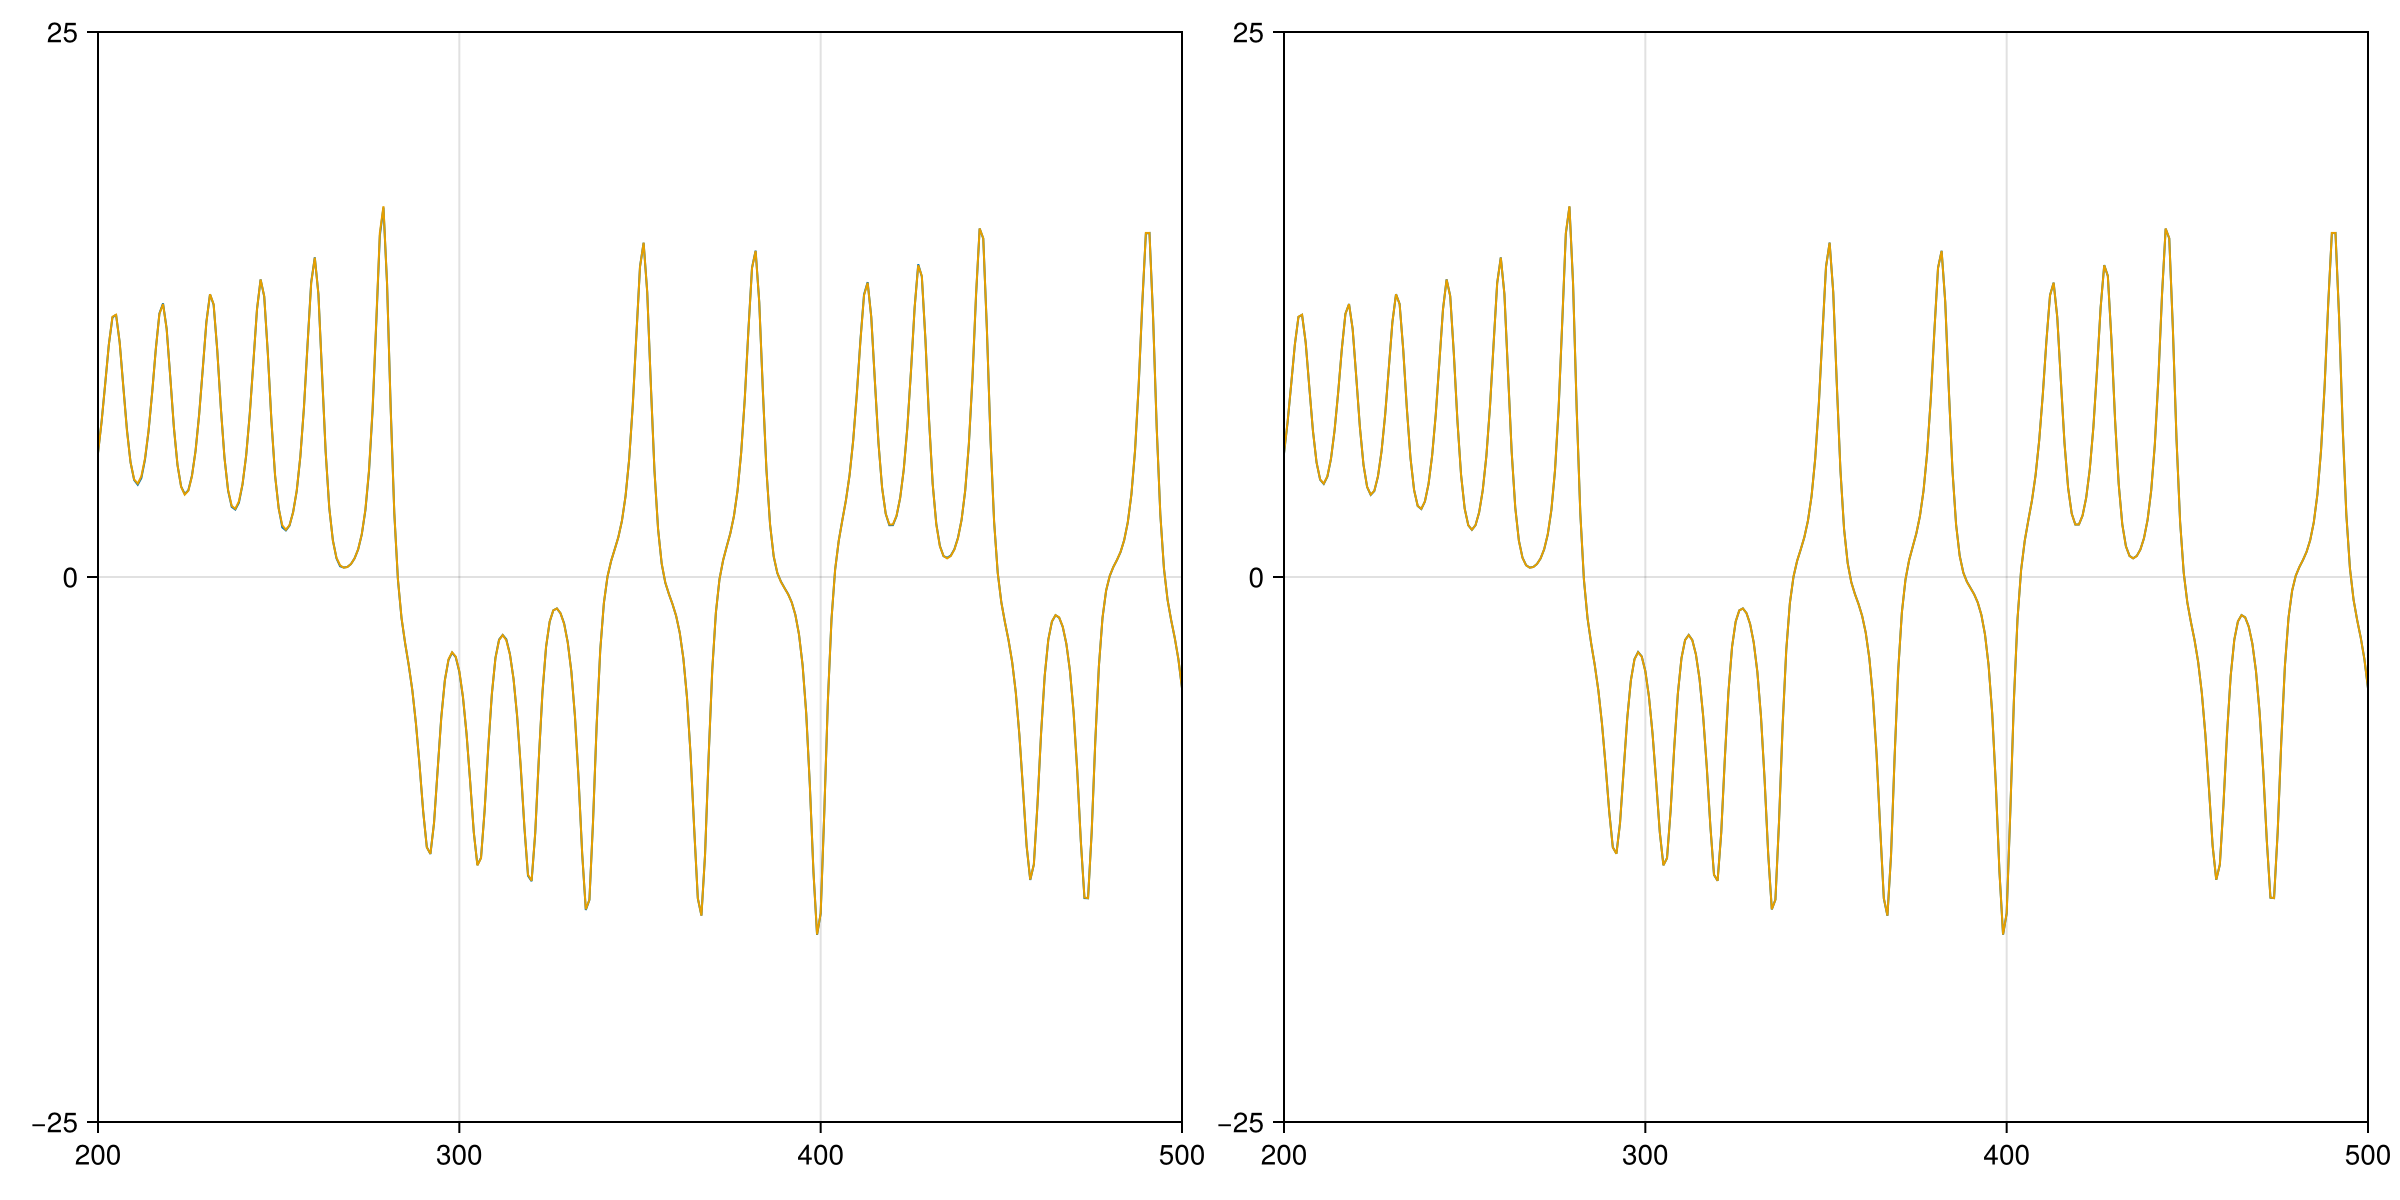

CairoMakie.Screen{IMAGE}


In [67]:
fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, ON_preds; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(200,500)
ylims!(-25,25)

ax2 = Axis(fig[1,2])
lines!(ax2, vanilla_preds; linewidth = 1.0, color = Cycled(1))
lines!(ax2, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(200,500)
ylims!(-25,25)

display(fig)

In [68]:
ON_preds = create_pred_for_params(4; k = 10, d=2, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 40)

println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds, lo_test[2:length(ON_preds)+1]))
println("Vanilla prediction RMSE: ", RMSE(vanilla_preds, lo_test[2:length(vanilla_preds)+1]))

Ordinal network reservoir prediction RMSE: 0.8028741671603351
Vanilla prediction RMSE: 0.0690400547320861


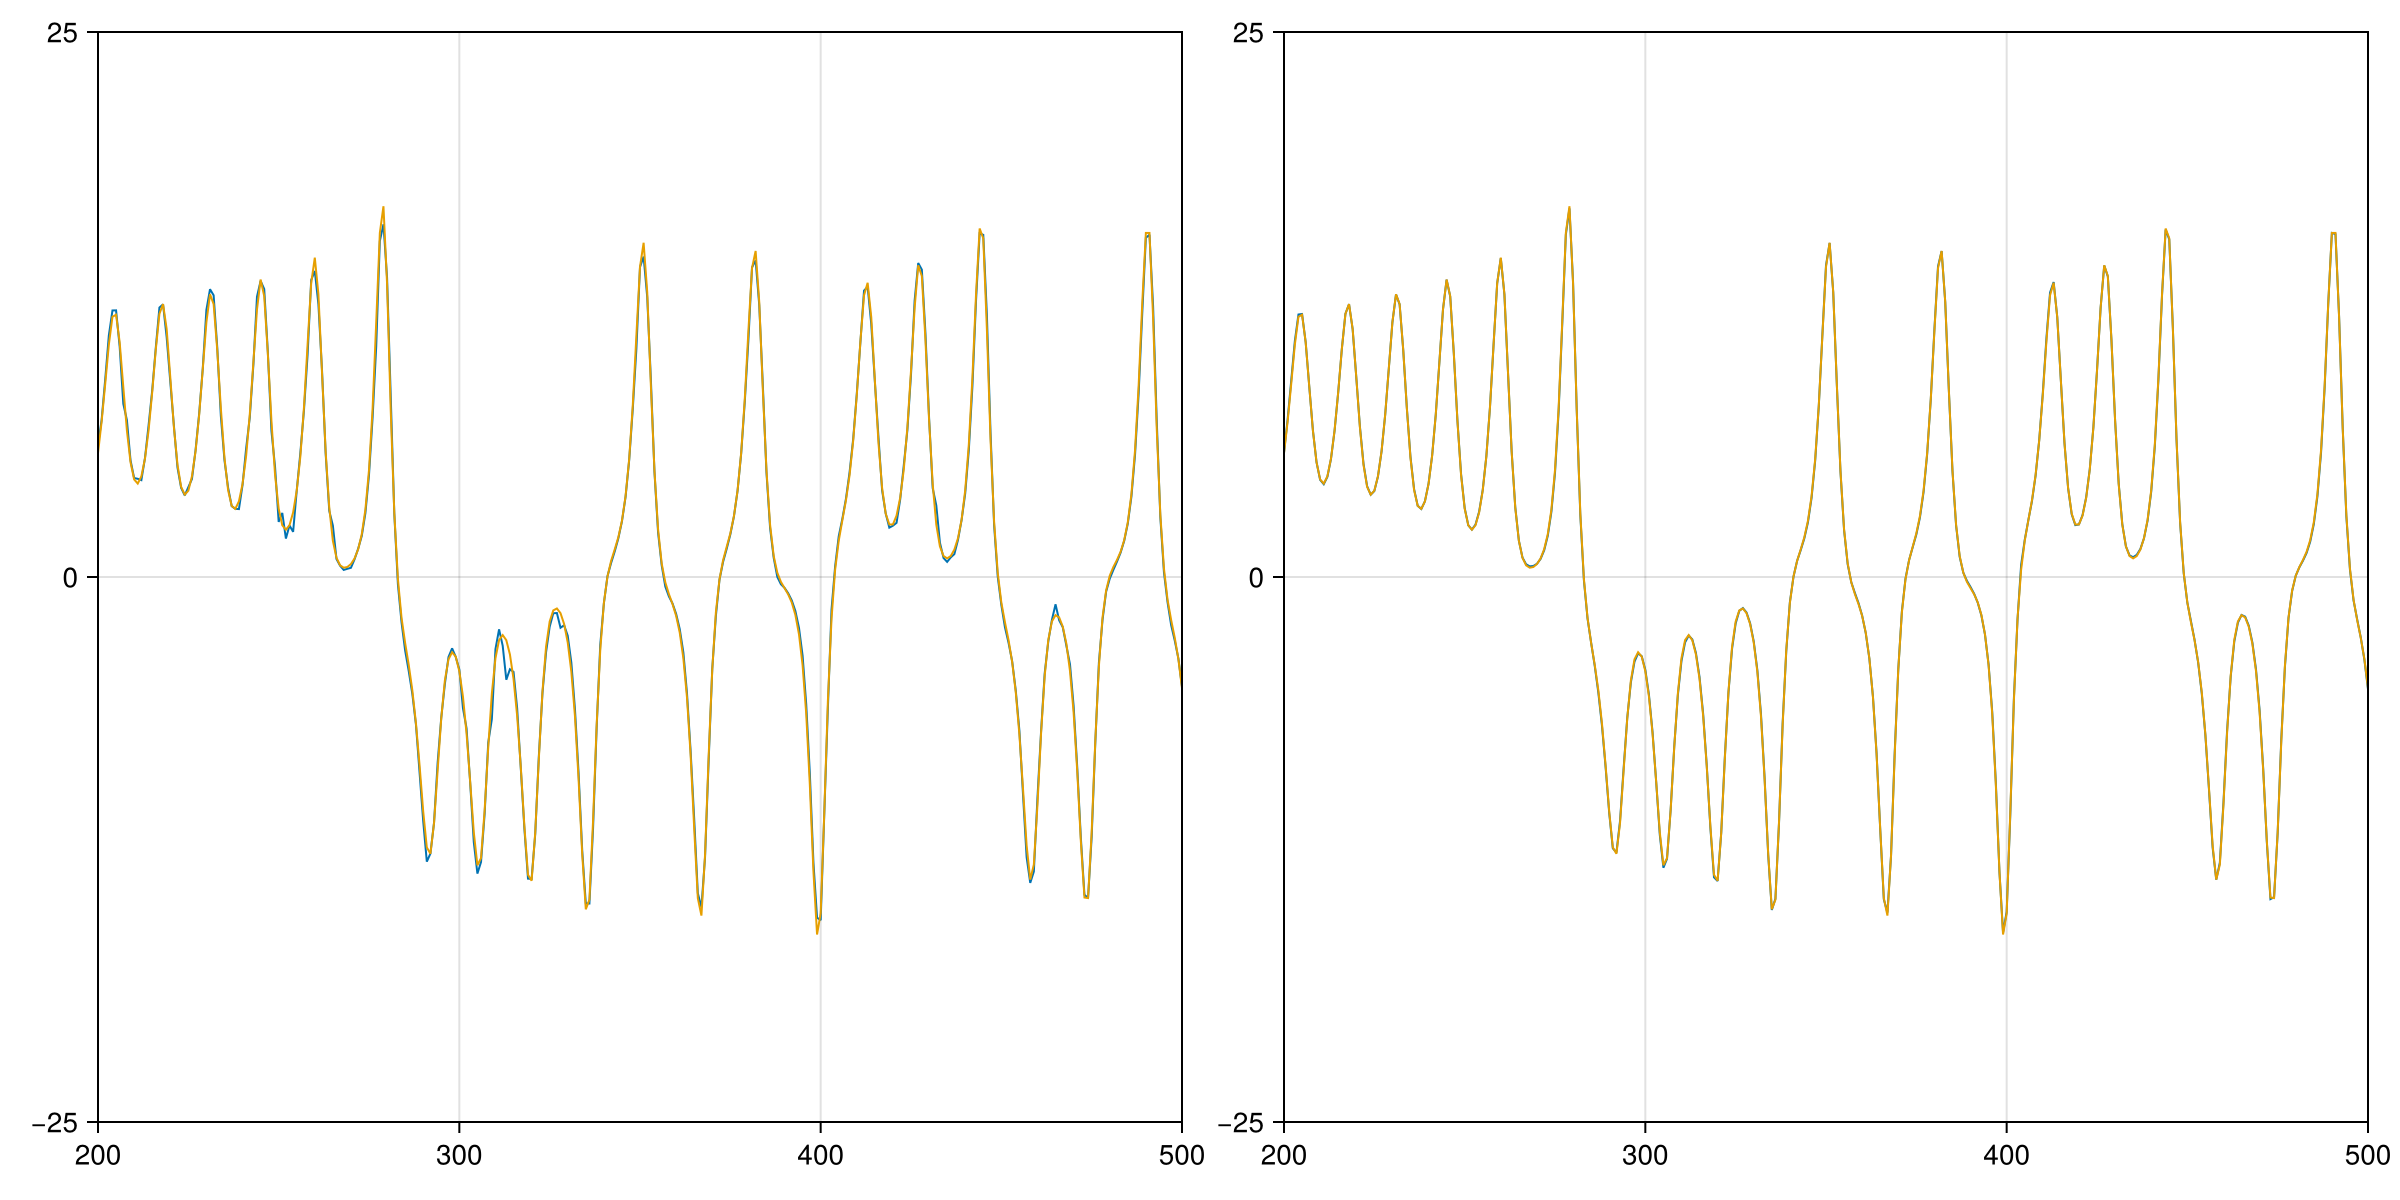

CairoMakie.Screen{IMAGE}


In [69]:
fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, ON_preds; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(200,500)
ylims!(-25,25)

ax2 = Axis(fig[1,2])
lines!(ax2, vanilla_preds; linewidth = 1.0, color = Cycled(1))
lines!(ax2, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(200,500)
ylims!(-25,25)

display(fig)

## Freerun predictions

In [70]:
function create_pred_for_params_free_run(m; k = 100, d = k*0.05, ρ = 1.2, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 2)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.1, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = [lo_test[i]]
    state = train_states[end,:]
    for i in 1:length(part_symbols_test)
        one_pred, one_state = one_step_pred(preds[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        pred = one_pred[1]
        state = one_state[1,:]
        push!(preds, pred)
    end
    
    return(preds)
end

create_pred_for_params_free_run (generic function with 1 method)

In [71]:
ON_preds_freerun = create_pred_for_params(4; k = 100, d=10)
vanilla_preds_freerun = create_pred_for_params(1; k = 400)

# println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds, lo_test[2:length(ON_preds)+1]))
# println("Vanilla prediction RMSE: ", RMSE(vanilla_preds, lo_test[2:length(vanilla_preds)+1]))

;

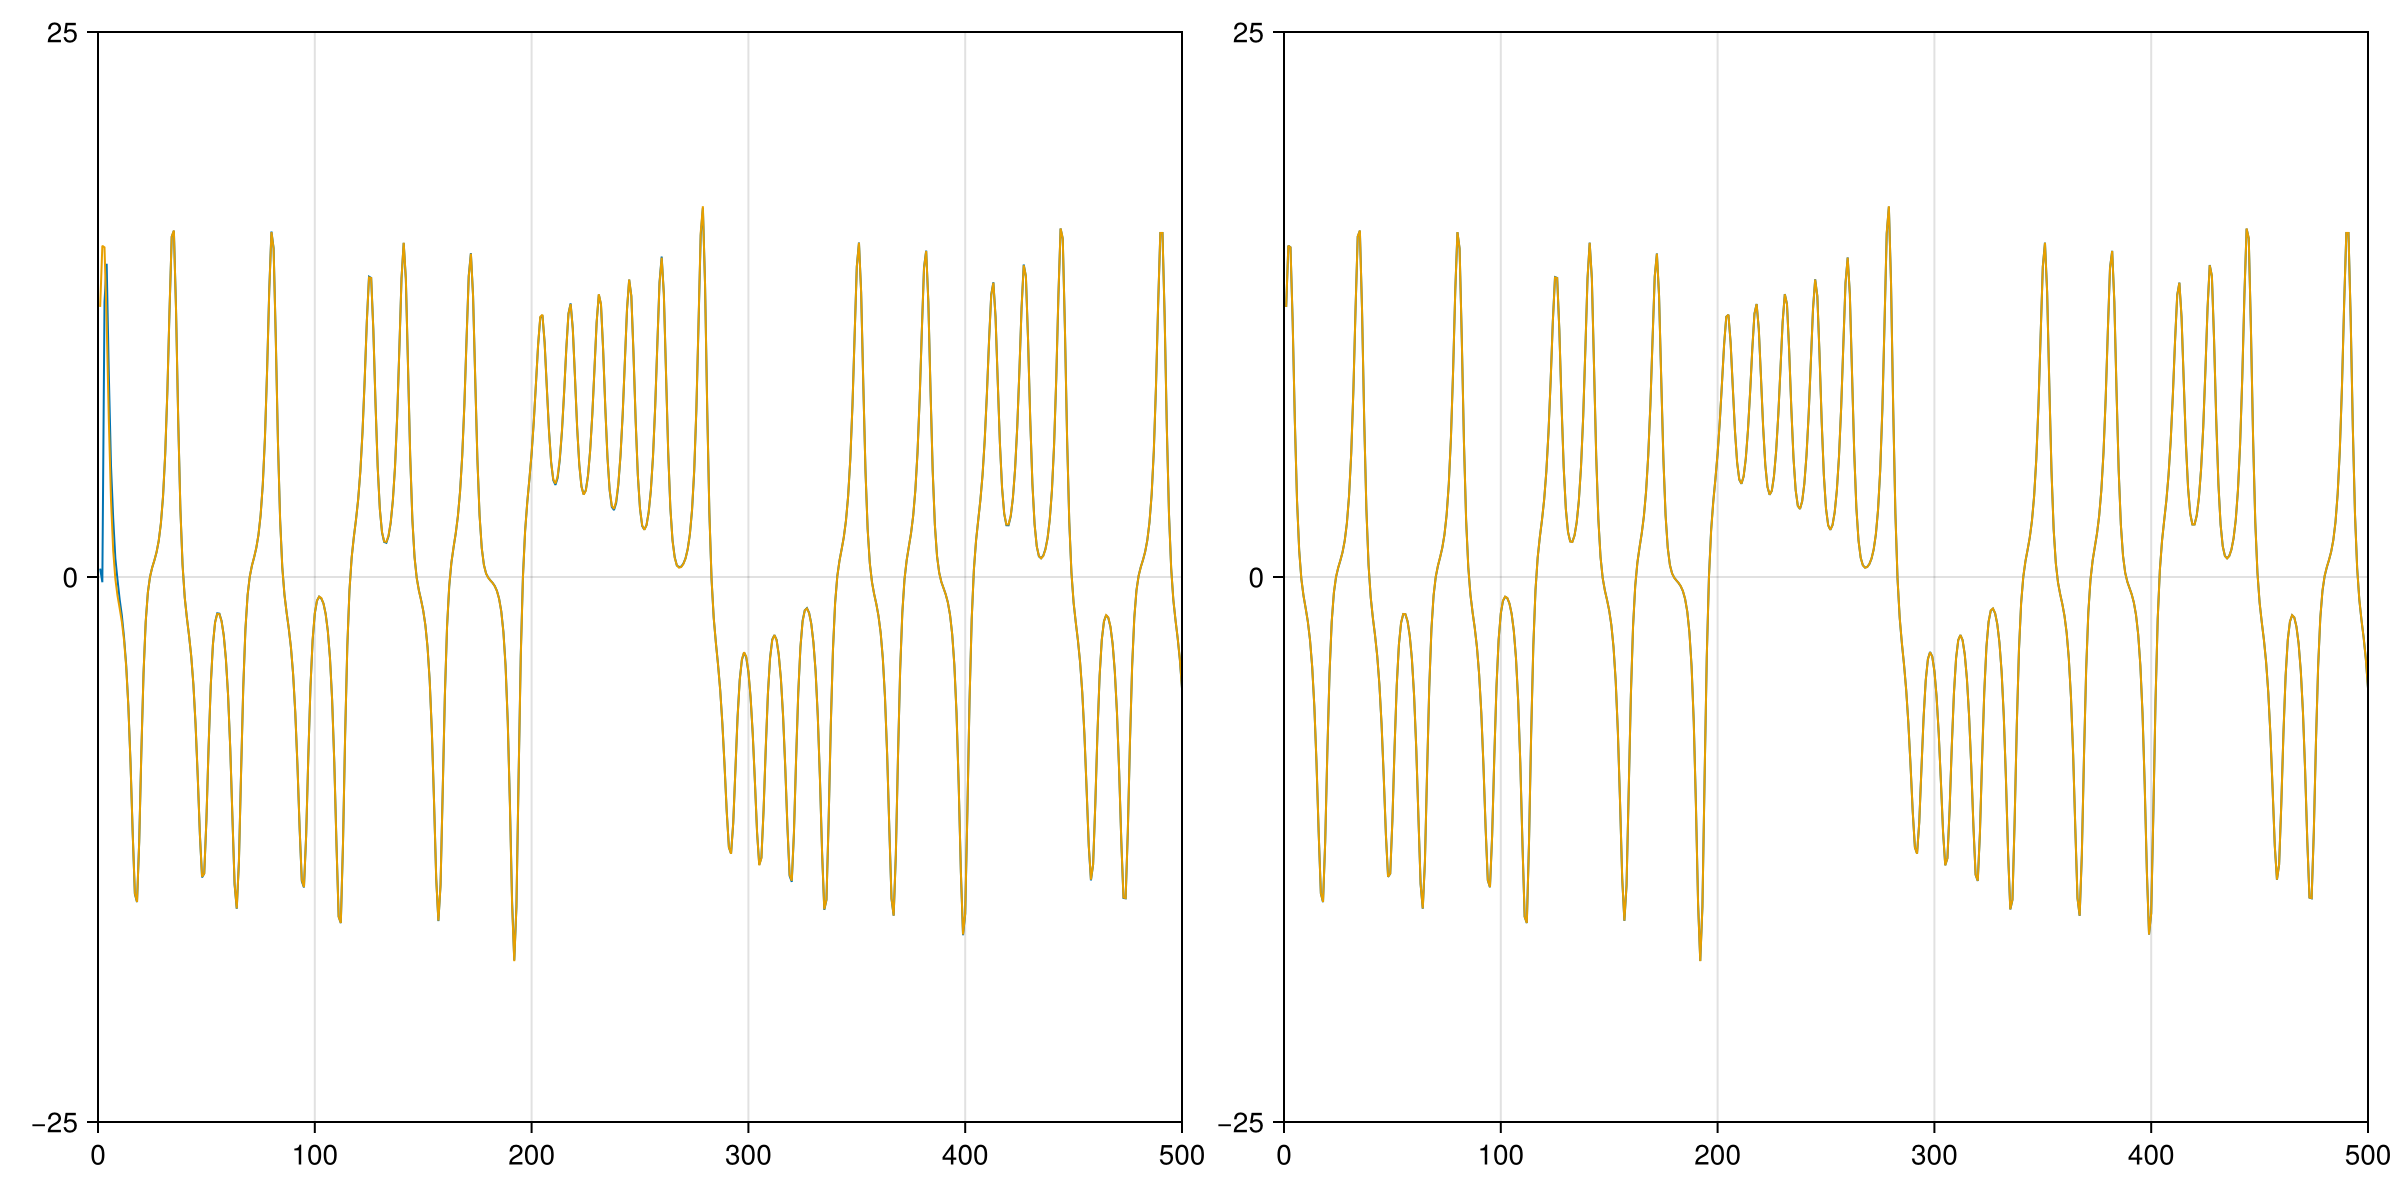

CairoMakie.Screen{IMAGE}


In [73]:
fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, ON_preds_freerun; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(0,500)
ylims!(-25,25)

ax2 = Axis(fig[1,2])
lines!(ax2, vanilla_preds_freerun; linewidth = 1.0, color = Cycled(1))
lines!(ax2, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(0,500)
ylims!(-25,25)

display(fig)

## Multi step predictions

In [74]:
function multi_step_pred(initial_value, sub_part_symbols_test, state, R, ESN_params)
    preds = []
    pred, state = initial_value, state
    
    for i in 1:length(sub_part_symbols_test)
        one_pred, one_state = one_step_pred(pred, ESN_params, R, S = state, partition_symbols=sub_part_symbols_test[i])
        pred = one_pred[1]
        state = one_state[1,:]
        push!(preds, pred)
    end
    
    return(preds, state)
end

function create_pred_for_params_multi_step(m, chunk_length; k = 100, d = k*0.05, ρ = 1.2, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 2)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.5, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    # preds = [one_step_pred(lo_test[i], ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test[i])[1][1] for i in 1:length(part_symbols_test)]
    preds = []
    current_state = train_states[end,:]
    i = 1
    while i+chunk_length < length(part_symbols_test)
        new_preds, current_state = multi_step_pred(lo_test[i], part_symbols_test[i:i+chunk_length], current_state, R, ESN_params)
        preds = vcat(preds, new_preds)
        
        i = i + chunk_length
    end
    
    return(preds)
end

create_pred_for_params_multi_step (generic function with 1 method)

In [75]:
ON_preds_multistep = create_pred_for_params_multi_step(4, 10; k = 100, d=10)
vanilla_preds_multistep = create_pred_for_params(1; k = 400)

println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds, lo_test[2:length(ON_preds)+1]))
println("Vanilla prediction RMSE: ", RMSE(vanilla_preds, lo_test[2:length(vanilla_preds)+1]))

Ordinal network reservoir prediction RMSE: 0.8028741671603351
Vanilla prediction RMSE: 0.0690400547320861


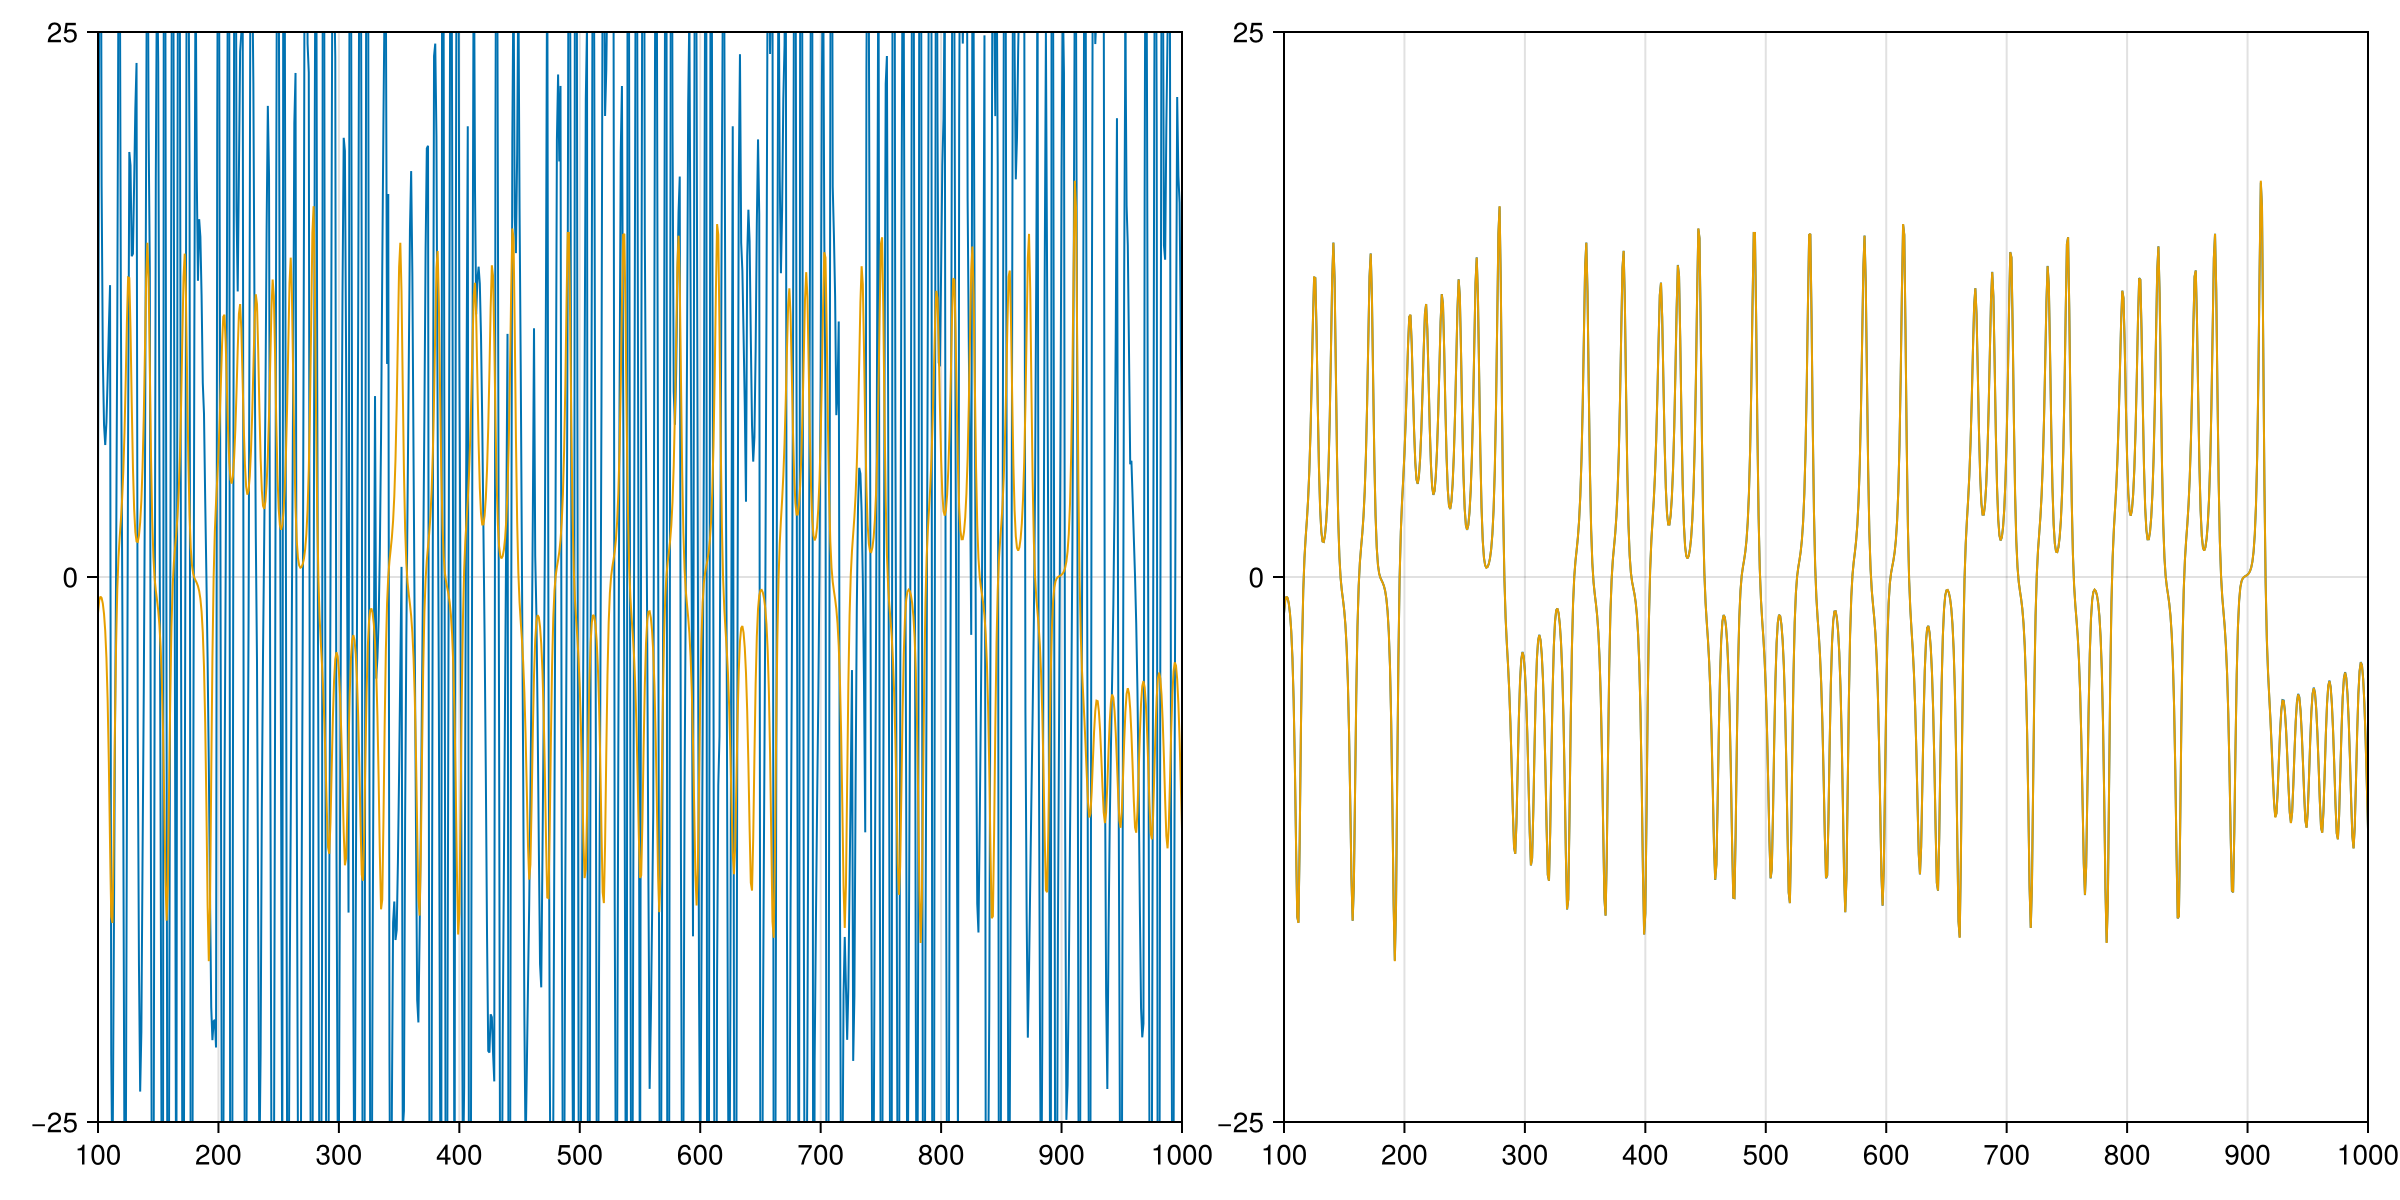

CairoMakie.Screen{IMAGE}


In [77]:
fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, ON_preds_multistep; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(100,1000)
ylims!(-25,25)

ax2 = Axis(fig[1,2])
lines!(ax2, vanilla_preds_multistep; linewidth = 1.0, color = Cycled(1))
lines!(ax2, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(100,1000)
ylims!(-25,25)

display(fig)

In [11]:
function train_one_step_pred(x, ESN_params)
    states = run_ESN(x, ESN_params)
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

In [12]:
function calculate_corr_coeffs(ESN_params, max_τ, x_length)
    u_train = randn(x_length)
    u_test = randn(x_length)
    corr_coeffs = zeros(max_τ+1)
    states_train = run_ESN(u_train, ESN_params)
    states_test = run_ESN(u_test, ESN_params)
    
    train_time = 0
    test_time = 0
    mse = 0

    for delay in 0:1:max_τ
        
        # Train an R for remembering the input 'delay' steps ago
        states_train_later = states_train[1+delay:size(states_train)[1],:]
        u_train_earlier = u_train[1:length(u_train)-delay]
        
        beginning_time = time_ns()

        R = ridge_regression(u_train_earlier, states_train_later, ESN_params.β)
        
        train_time += (time_ns()-beginning_time)/1000000
        
        states_test_later = states_test[1+delay:size(states_test)[1],:]
        u_test_earlier = u_test[1:length(u_test)-delay]
        
        beginning_time = time_ns()
        
        # Make the recollections
        test_preds = states_test_later * R
        
        test_time += (time_ns()-beginning_time)/1000000
        
        mse += mean((u_test_earlier-test_preds).^2)
        
        # Save errors (as correlation)
        corr_coeffs[delay+1] = cor(u_test_earlier, test_preds)#^2
    end
    
    println("Average train time: ", train_time/max_τ)
    println("Average test time: ", test_time/max_τ)
    println("MSE: ", mse/max_τ)
    
    return(corr_coeffs)
end

calculate_corr_coeffs (generic function with 1 method)

In [13]:
function find_max_delay(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    return(findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ))
end

find_max_delay (generic function with 1 method)

In [14]:
function plot_memory_capacity(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    MCs = cumsum(corr_coeffs)
    
    fig = Figure( size = (800,400), fonts = (; regular = "Tex"), fontsize = 12)
    lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
    ylims!(-0.1,1.1)
    lines!(Axis(fig[1,2], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
    ylims!(0,maximum(MCs)+1)
    
    println(string(
        "Memory capacity: ",
        findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ)
    ))
    
    return(fig)
end

plot_memory_capacity (generic function with 1 method)

In [15]:
function one_step_errors(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)

    return(cor(lo_test[2:end], preds[1:length(preds)-1]))
end

one_step_errors (generic function with 1 method)

In [16]:
function plot_one_step_test(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)
    
    fig = Figure( size = (1200,600))
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(0,200)
    ylims!(-25,25)
    
    ax1 = Axis(fig[2,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(length(lo_test)-200,length(lo_test))
    ylims!(-25,25)
    display(fig)
    
    println(string("Error (correlation): ", cor(preds[1:end-1], lo_test[2:end])))
end

plot_one_step_test (generic function with 1 method)

In [17]:
k = 100
d = k*0.05
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

ESNParameters([0.9847366493411603, -0.06338359748662611, -0.7439631422803787, -0.6362837999347926, 0.1337756936224495, -0.17253303921367155, -0.6305956581556434, 0.41475348571621246, 0.6787734758453596, -1.3258363474119141  …  -2.7419280106303052, 0.6737032983713201, 0.3066566583431404, 0.9123331960977697, 0.9314152643724954, 1.275873547683693, 0.051473703547856374, 0.4992499296386518, -1.0456972895153955, -0.8400641400010506], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.8178241214907904, 1.149754070636986, 0.41310447618751595, 1.1000655065521432, -0.7159234019054107, -1.0180962885029323, 2.0471492429554488, 0.4077567675535083, 0.2114907418572612, -1.0767424576053322  …  1.229092249904507, -0.08095663186254118, 1.2217955979303416, -0.8144727224020745, 1.3805141897062327, 0.3742712986527654, 1.1970853276415765, 0.045479574073864, -0.6798722445286091, 2.370383603021396], 100, 1.0, 0.0565917388437432, 0.001)

## One-step Prediction, Correlation (error) and Memory Capacity

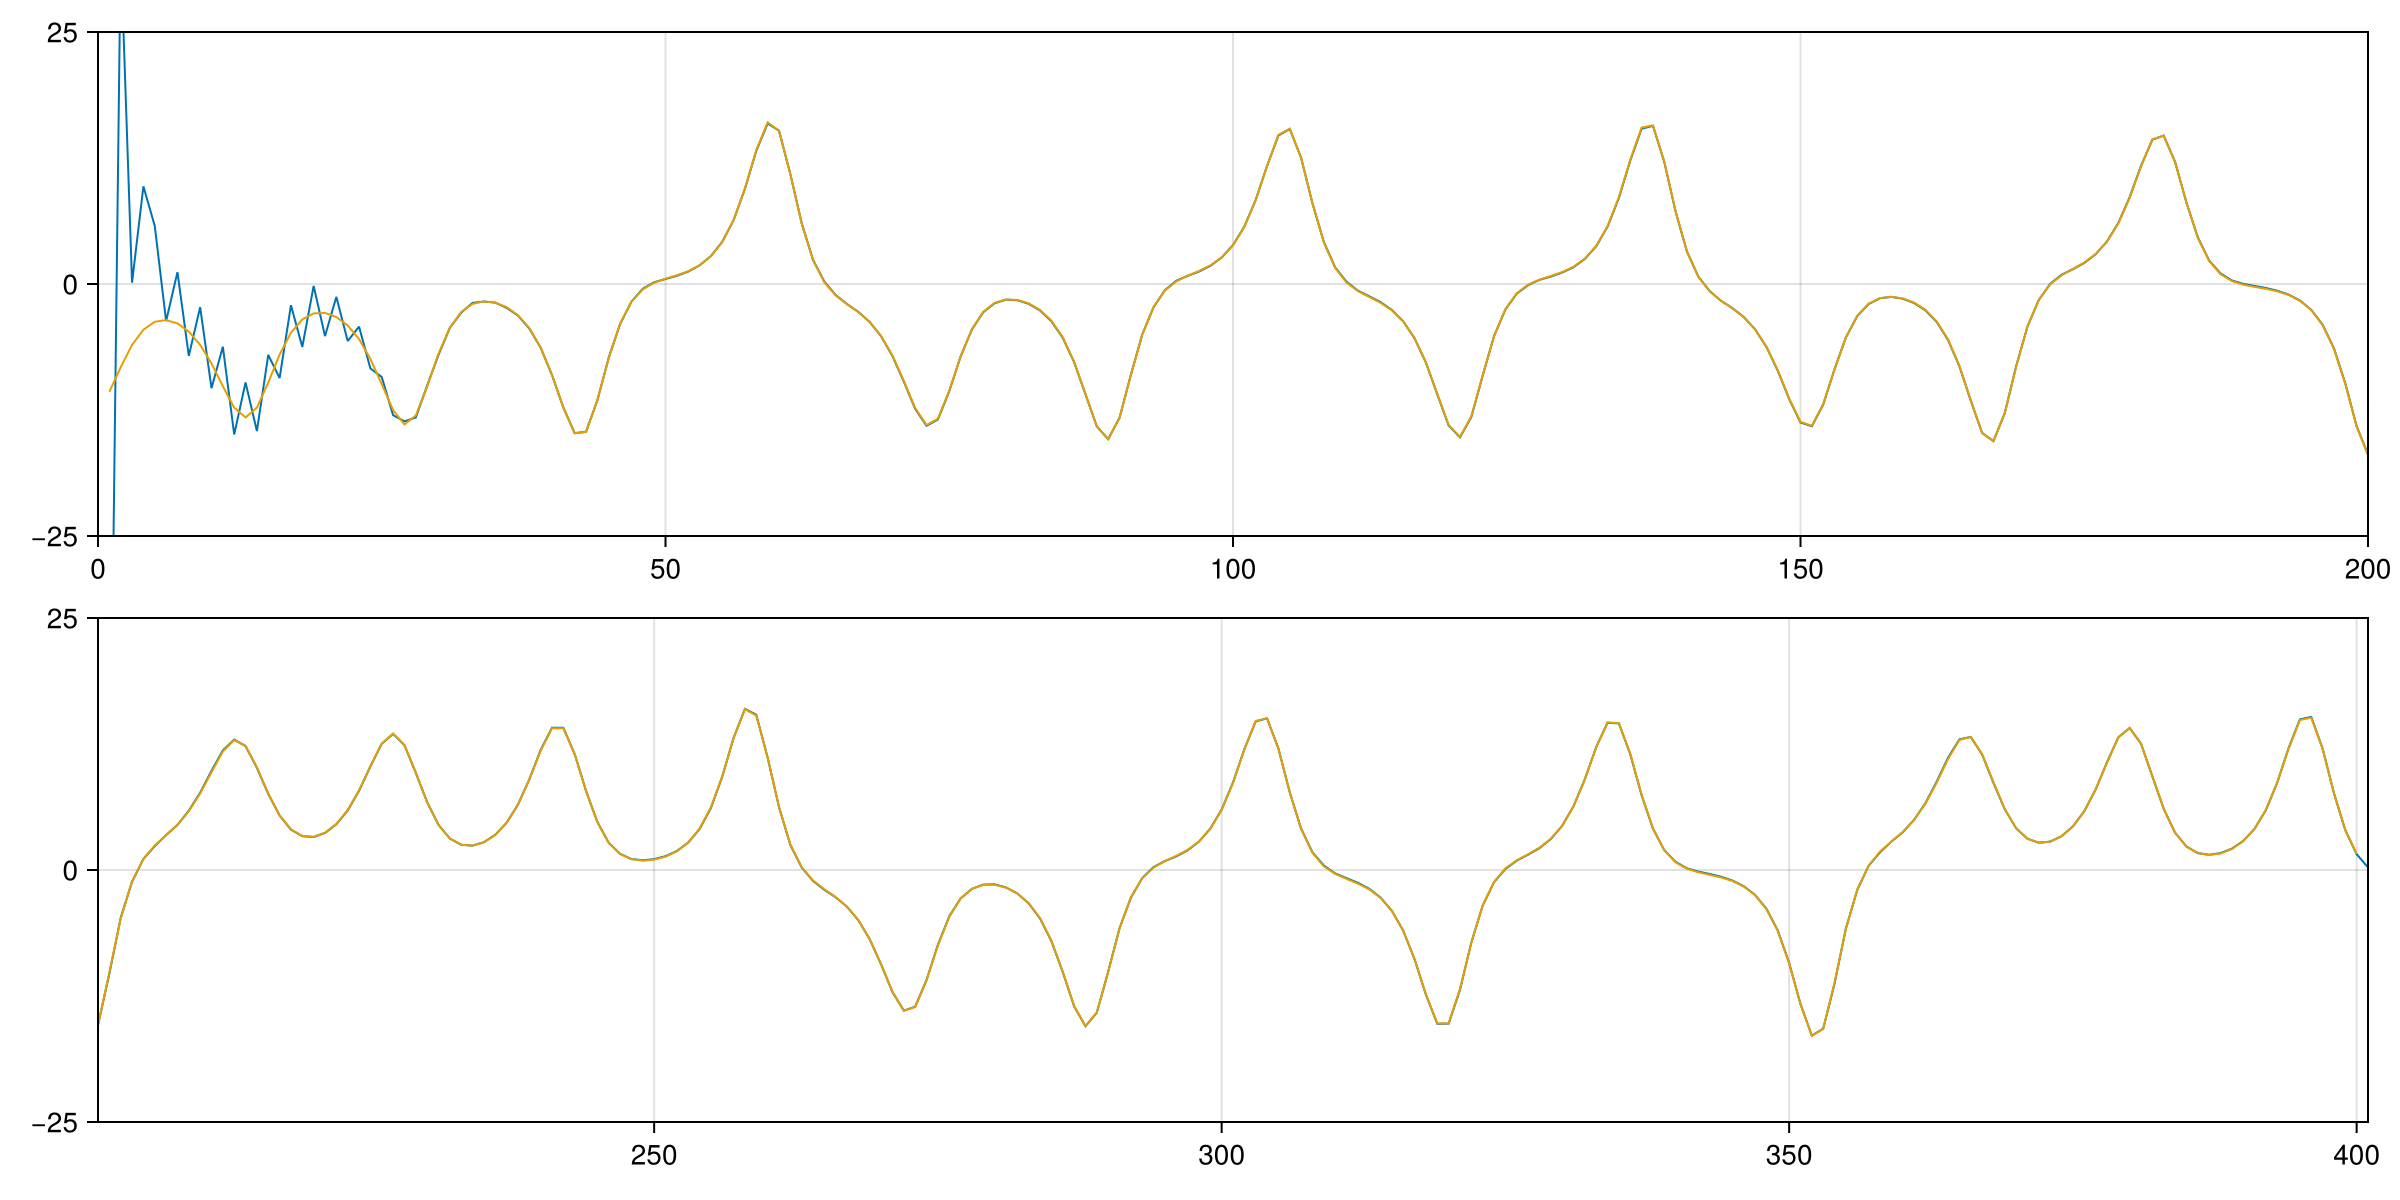

Error (correlation): 0.9201043583144938
Average train time: 4.019523433333334
Average test time: 0.28861943333333334
MSE: 3.0551903910387623
Memory capacity: 30


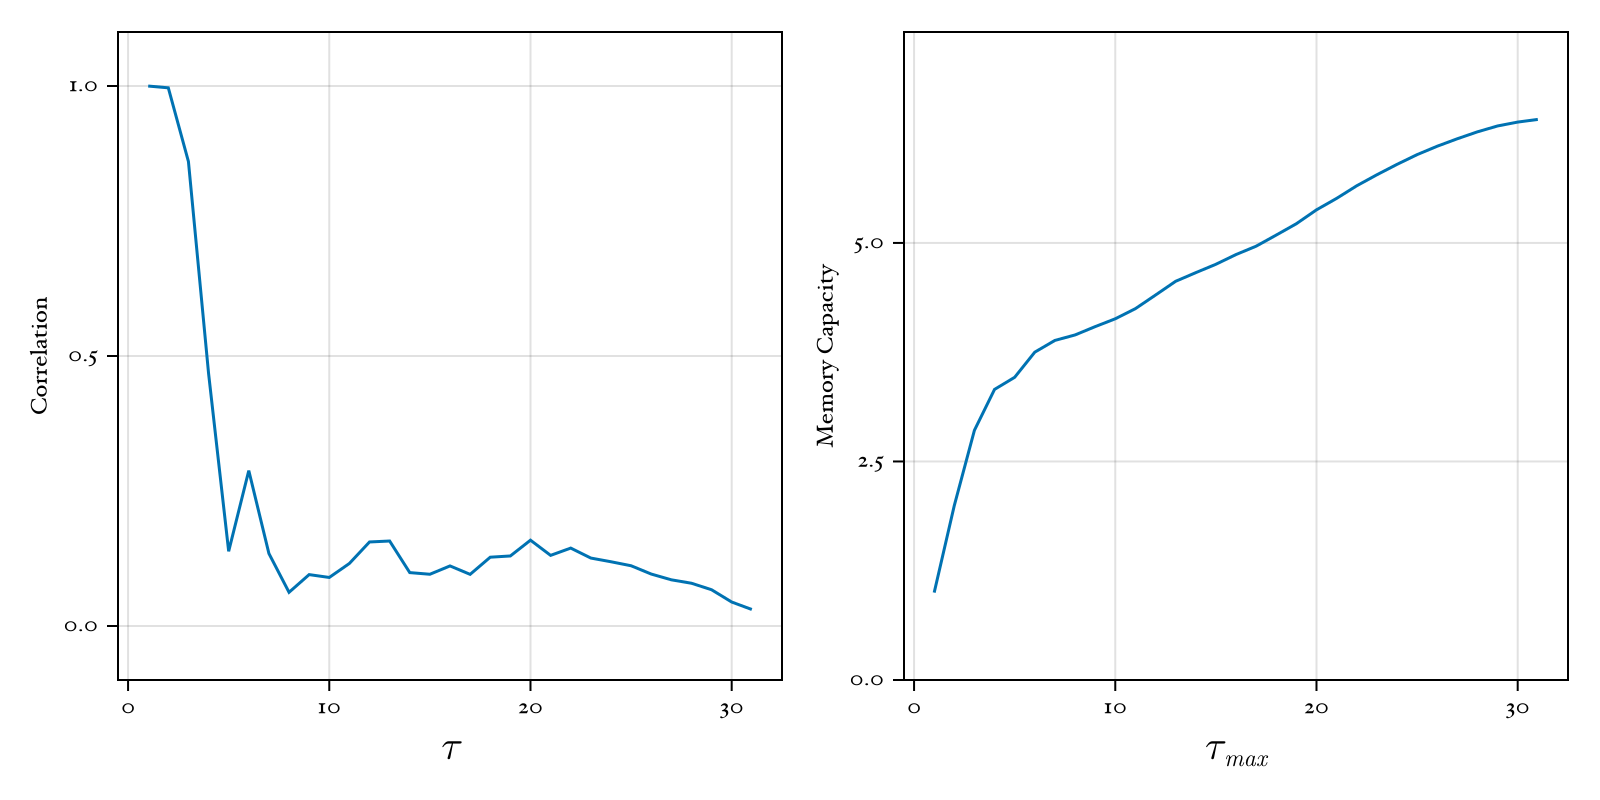

In [18]:
plot_one_step_test(ESN_params)
mem_cap_fig = plot_memory_capacity(ESN_params, 30, 10000)

In [22]:
rho_test_range = 0:0.01:5.0
rho_test_errs = [one_step_errors(create_ESN_params(k, d, ρ_i, α, η, β)) for ρ_i in rho_test_range]

501-element Vector{Float64}:
  0.9630293005922232
  0.9925727778578414
  0.9945694783361773
  0.9851732189087578
  0.9937161870243921
  0.9973256133781453
  0.9995737769591266
  0.9985005317701207
  0.9981975684757867
  0.9971626884738292
  0.997126890952867
  0.9918958131582067
  0.9828350763453172
  ⋮
  0.5540132779055039
 -0.21610526899259572
  0.38425802549754995
  0.07403591195628999
 -0.8961574687724103
 -0.026201098419415307
  0.6381387925136379
  0.2064145940195578
  0.6797661657181463
 -0.020519533872750552
 -0.8048699571524728
 -0.037748442520035445

In [19]:
# save("memory_capacity.pdf", mem_cap_fig)

Average train time: 2.8030686333333326
Average test time: 0.26977539999999994
MSE: 0.8443432605953044


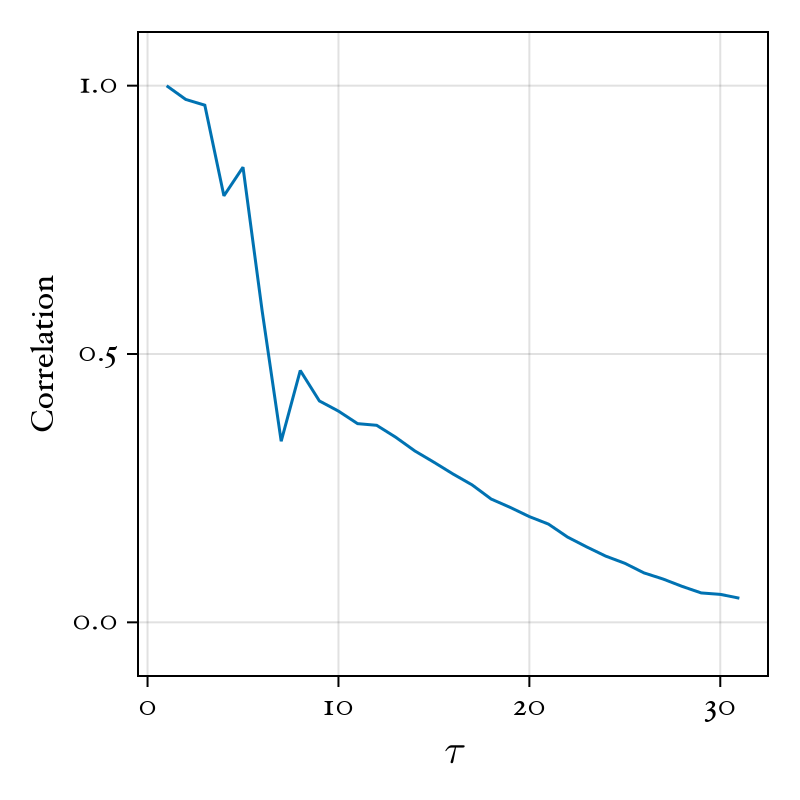

In [20]:
corr_coeffs = calculate_corr_coeffs(ESN_params, 30, 10000)
MCs = cumsum(corr_coeffs)

fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)
lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
ylims!(-0.1,1.1)

# save("correlation.pdf", fig)

fig

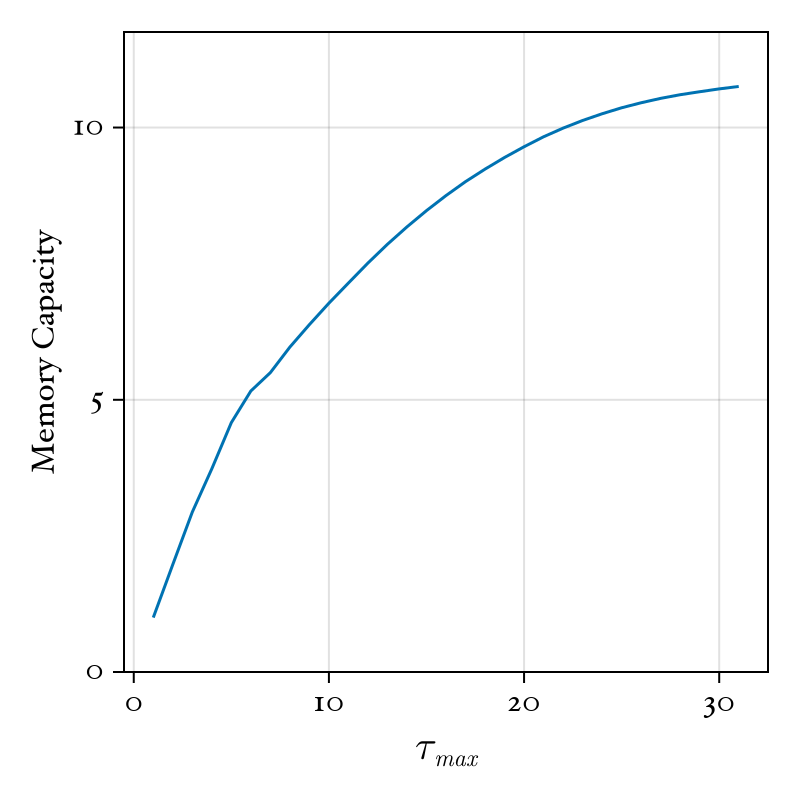

In [21]:
fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)

lines!(Axis(fig[1,1], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
ylims!(0,maximum(MCs)+1)

# save("memory_capacity.pdf", fig)

fig

## Spectral radius vs error (correlation)

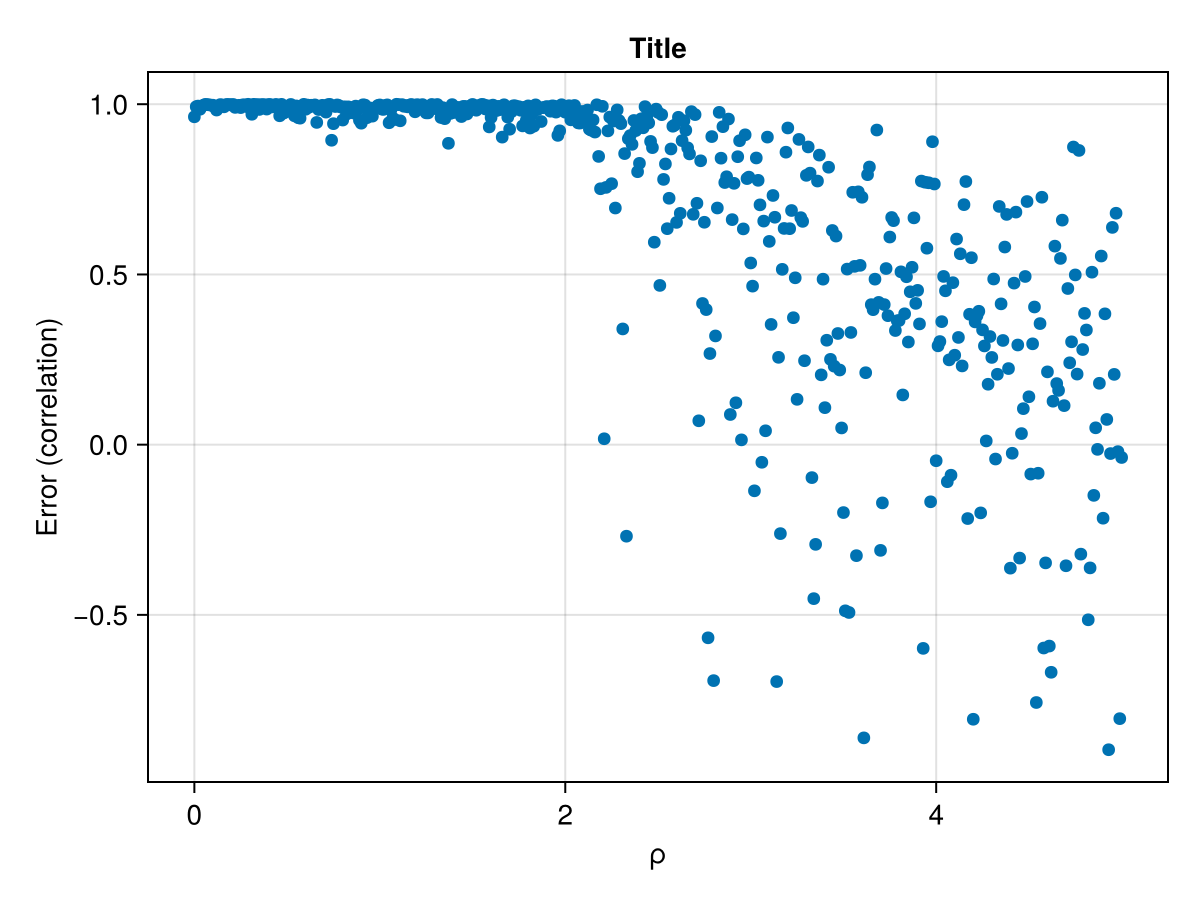

In [23]:
# plot(collect(rho_test_range),
#     rho_test_errs)
f = Figure()

ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Error (correlation)",
    title = "Title")
scatter!(collect(rho_test_range), rho_test_errs)

f

When the spectral radius is low, the correlation of the predicted to the actual trajectory appears to be high (approximately 1). As the spectral radius increases, the correlation drops and becomes more distributed randomly between -1 and 1. The correlation begins to drop between ρ=1 and ρ=2 and appears randomly distributed above around ρ=2.5.

## Spectral radius vs memory capacity

In [24]:
# rho_test_mems = [find_max_delay(create_ESN_params(k, d, ρ_i, α, η, β), 30, 10000)
#         for ρ_i in rho_test_range]

In [25]:
# f = Figure(size = (600, 400), fontsize = 12, fonts = (; regular = "Tex", weird = "Blackchancery"))

# ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Memory Capacity",
#     title = "Memory Capacity vs. ρ", titlefont=:regular)
# scatter!(collect(rho_test_range), rho_test_mems)
# # set_theme!(font="Computer Modern")

# f

In [26]:
# save("memory capacity vs rho.pdf", f)#, pdf_version="1.4")

In [27]:
# ρ = 1.0
# k_test_range = [10,20,40,80,160]#50,100,200]#,500,1000]

# for k_i in k_test_range
#     println(k_i)
# #     
#     K_test_mem = find_max_delay(create_ESN_params(k_i, k_i*0.05, ρ, α, η, β), 30, 100000)
    
#     println(K_test_mem)
# end

As the spectral radius increases, the memory capacity generally increases up to around ρ=1.5 to ρ=2, afterwhich it decreases and plateaus around 1 to 6. After around ρ=1, the memory capacity becomes more variable, increasing from range of approximately 3-4 to a range of approximately 15.

## Freerun prediction

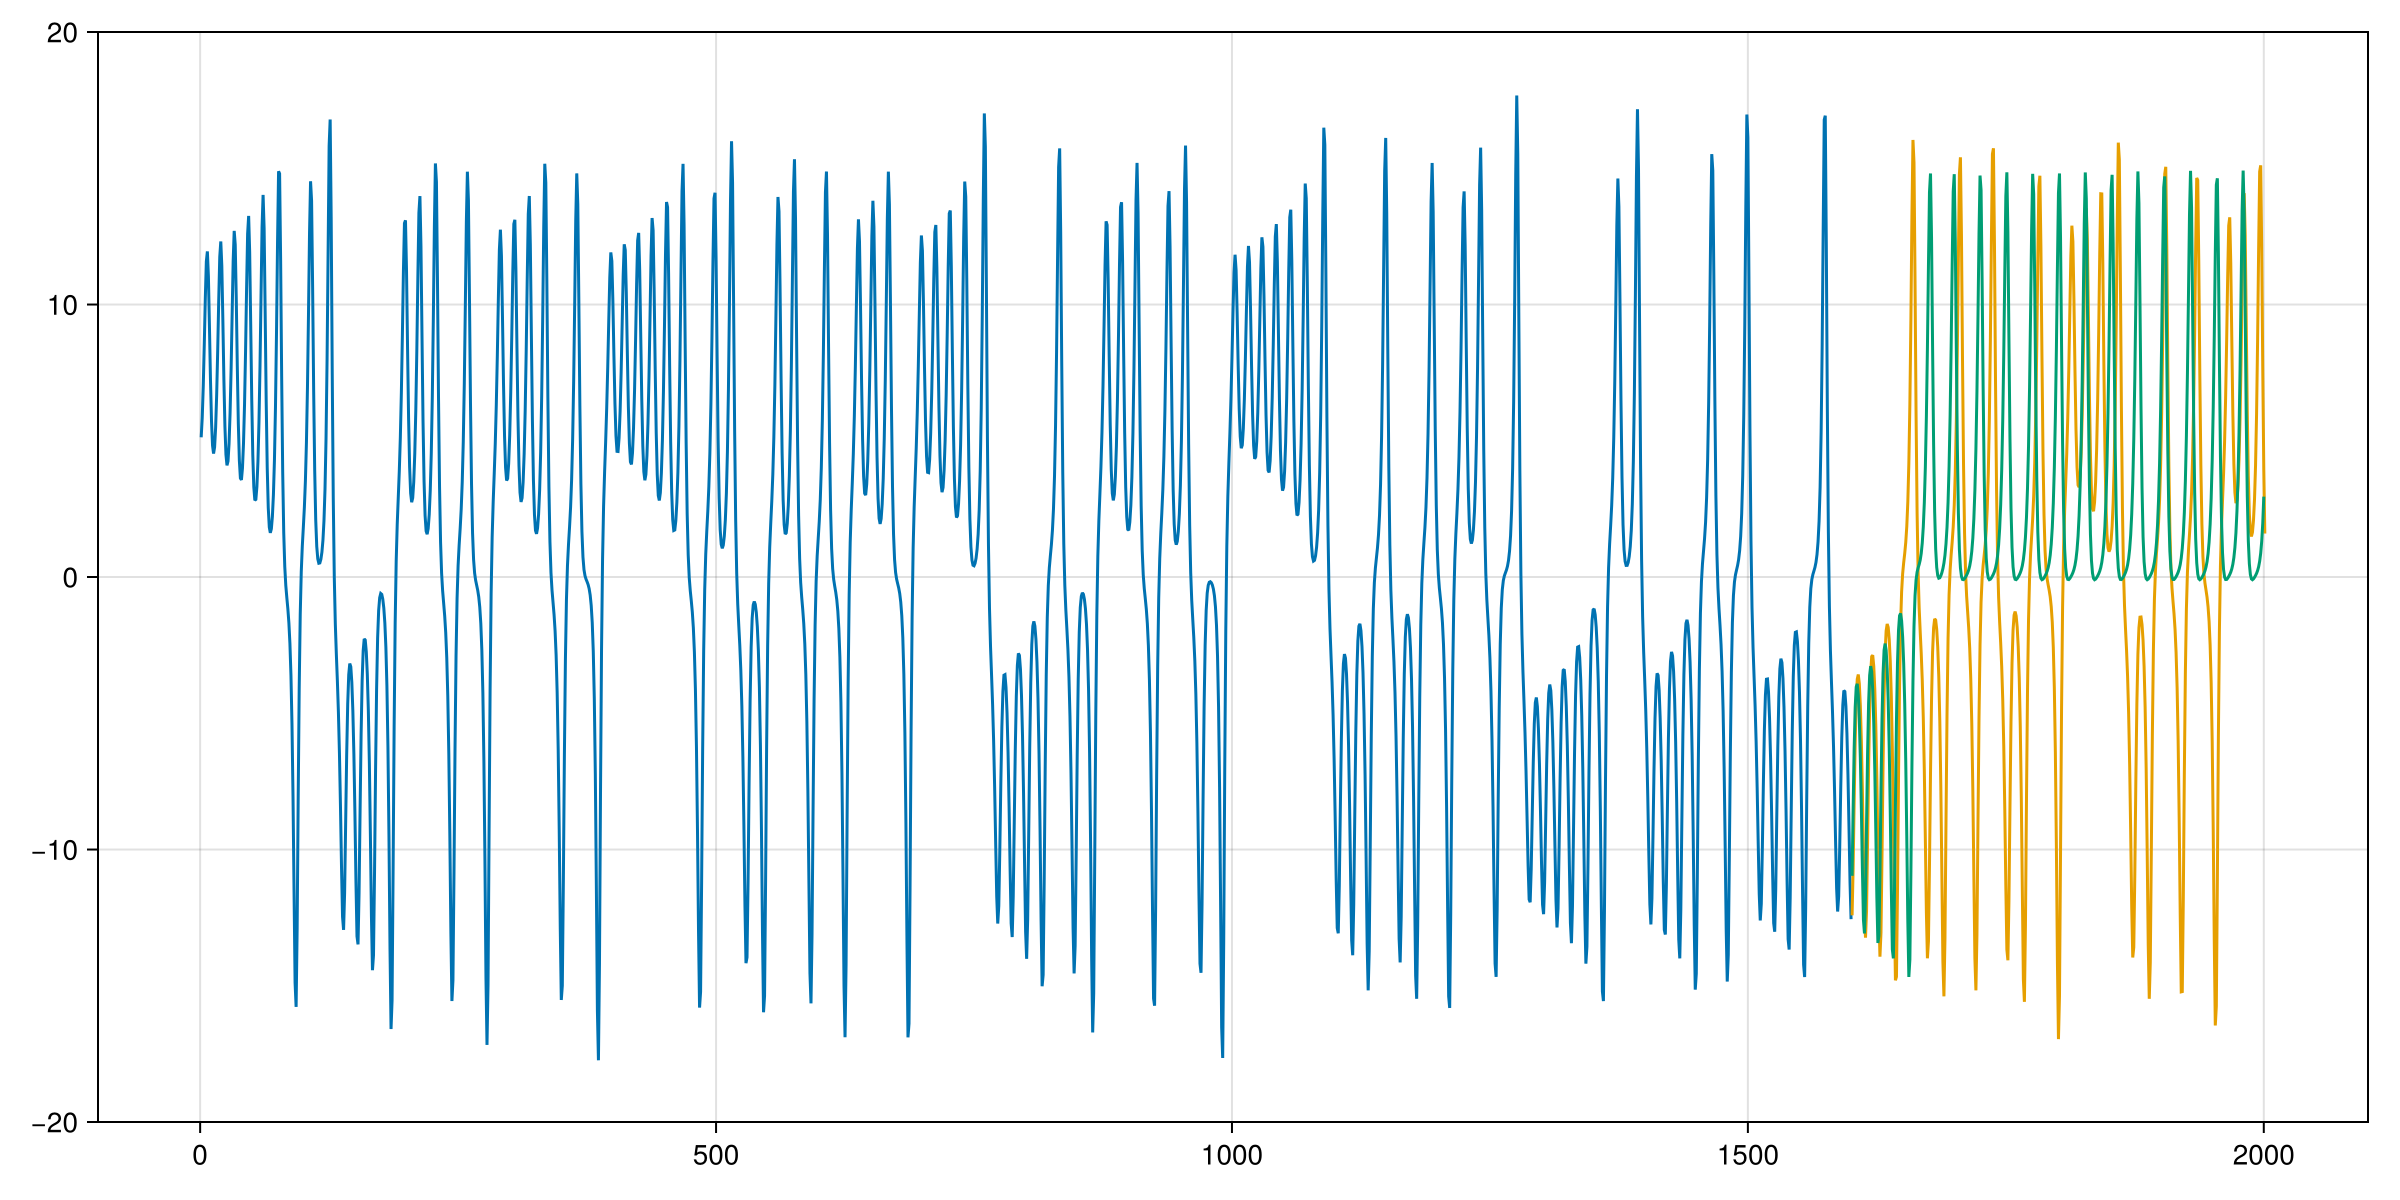

In [28]:
k = 50
d = k*0.05
ρ = 1.1
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)
R, train_states = train_one_step_pred(lo_train, ESN_params)


num_pred_steps = 400

current_state = train_states[end, :]
pred = [lo_train[end]]

preds = zeros(num_pred_steps)

for i in 1:num_pred_steps
    pred, current_state = one_step_pred(pred, ESN_params, R; S=current_state)

    current_state = current_state'
    preds[i] = pred[1]
end


fig = Figure( size = (1200,600) )
ax = Axis(fig[1,1])
lines!(ax, lo_train)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(lo_test)-1, lo_test)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(preds)-1, preds)
# xlims!(600,1000)
ylims!(-20,20)
fig

In [29]:
function train_one_step_pred(x, ESN_params; states=nothing)
    if states != nothing
        states = run_ESN(x, ESN_params)
    end
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

# Ordinal Readout Switching

In [31]:
function train_one_step_pred_with_mask(x, ESN_params, mask; states = nothing)
    if states == nothing
        states = run_ESN(x, ESN_params)
    end
    
    target_z = x[[false; mask[1:end-1]]]
    predicted_states = states[1:size(states)[1]-1,:][mask[1:end-1],:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = nothing)
    num_symbols = length(unique_partitions)
    Rs = Matrix(undef, num_symbols, ESN_params.k)

    for i in 1:num_symbols
        part_mask = [part_symbols .== i; fill(false, window_size)]
        R, train_states = train_one_step_pred_with_mask(lo_train, ESN_params, part_mask; states=states)
        Rs[i, :] = R
    end
    
    return(Rs)
end

function one_step_pred_partitioned(x, ESN_params, Rs; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*Rs'
    
    return(preds, states)
end

one_step_pred_partitioned (generic function with 1 method)

In [32]:
function switch_prediction(y, prediction_series, unique_partitions, m, w, τ)
    part_symbols, _ = create_ordinal_partition(y, m, w, τ; unique_partitions = unique_partitions)
    switching_prediction = [prediction_series[i, part_symbols[i]] for i in 1:length(part_symbols)]
    
    return(switching_prediction)
end

switch_prediction (generic function with 1 method)

In [34]:
k = 50
d = k*0.05
ρ = 1.05
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

states = run_ESN(lo_train, ESN_params)

# Train regular ol' ESN
R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

# Create ordinal partition
m = 3
w = 1
τ = 2
window_size = (m-1)*τ
part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

# Train partition based readout
Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states=states)
# Create transition matrix and modify the partition based readout
transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

6×50 Matrix{Any}:
 7.31482  -1.62095   1.6136     2.56757   …  -6.40459  -8.2524   8.26278
 3.99623  -2.35644  -0.741951   0.495562     -3.26018  -2.13115  1.66894
 8.284    -4.8242   -6.98603   -0.215077     -4.14819  -3.57671  5.43941
 7.92359  -4.93449  -7.24192   -0.14523      -4.09465  -3.62673  5.55988
 3.56033  -4.66426  -4.07108    0.430393     -3.14985  -3.54919  4.3814
 7.85318  -1.60591   1.80321    2.85618   …  -6.79446  -9.06917  9.15173

In [35]:
preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
# switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])

([-10.864955373223903, -8.340288491271243, -6.096046705385451, -4.668081291559915, -3.971804484295939, -3.822876695752697, -4.138648237015474, -4.91110300812881, -6.18405364420287, -8.00511591311748  …  5.861663031774492, 8.468759534987623, 11.797969558824315, 14.677396807060287, 15.026988057417258, 12.12445531247024, 7.617079974815496, 3.866203115184069, 1.5172378039014855, 0.17974029112895984], [0.31701362127689947 0.34735664462427795 … -0.711166783610245 -0.4218484053661518; 0.3702549824788614 0.26156759529306284 … -0.7431601678630748 -0.45683768005358155; … ; 0.6399530165547667 -0.49339466966154966 … -0.8390570867149927 -0.8738760326220465; 0.6190056871469078 -0.38857117044488426 … -0.822772748158798 -0.8393231538497544])

In [36]:
start_skip = 10

println(cor(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end]))
println(cor(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)]))
println(cor(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)]))

0.9998158650078219


LoadError: UndefVarError: `switching_pred` not defined

In [37]:
for preds in [vanilla_preds, switching_pred, ON_modified_switching_pred]
    println(cor(preds[1+9:end-1], lo_test[2+9:length(preds)]))
    
    fig = Figure( size = (1200,600) )
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    # xlims!(0,300)
    ylims!(-25,25)
    display(fig)
end

LoadError: UndefVarError: `switching_pred` not defined

In [38]:
function freerun_prediction(R, current_state, ESN_params; switch=false, unique_partitions=nothing, window_size=nothing, m=nothing, w=nothing, τ=nothing)
    num_pred_steps = length(lo_test)
    
    if switch
        num_pred_steps = num_pred_steps - window_size
    end
    
    pred = [lo_train[end]]
    preds = zeros(num_pred_steps)

    for i in 1:num_pred_steps
        if switch
            all_preds, current_state = one_step_pred_partitioned(pred, ESN_params, R; S=current_state)
            pred = switch_prediction(lo_test[i:i+window_size], all_preds, unique_partitions, m, w, τ)
        else
            pred, current_state = one_step_pred(pred, ESN_params, R; S=current_state)
        end

        current_state = current_state'
        preds[i] = pred[1]
    end
    
    return(preds)
end

freerun_prediction (generic function with 1 method)

In [39]:
vanilla_freerun_preds = freerun_prediction(R, train_states[end, :], ESN_params)
switching_freerun_pred = freerun_prediction(Rs, train_states[end, :], ESN_params; switch=true, unique_partitions=unique_partitions, window_size=window_size, m=m, w=w, τ=τ)
ON_modified_switching_freerun_pred = freerun_prediction(transition_matrix_modified_Rs, train_states[end, :], ESN_params; switch=true, unique_partitions=unique_partitions, window_size=window_size, m=m, w=w, τ=τ)
;

0.11670168611510326


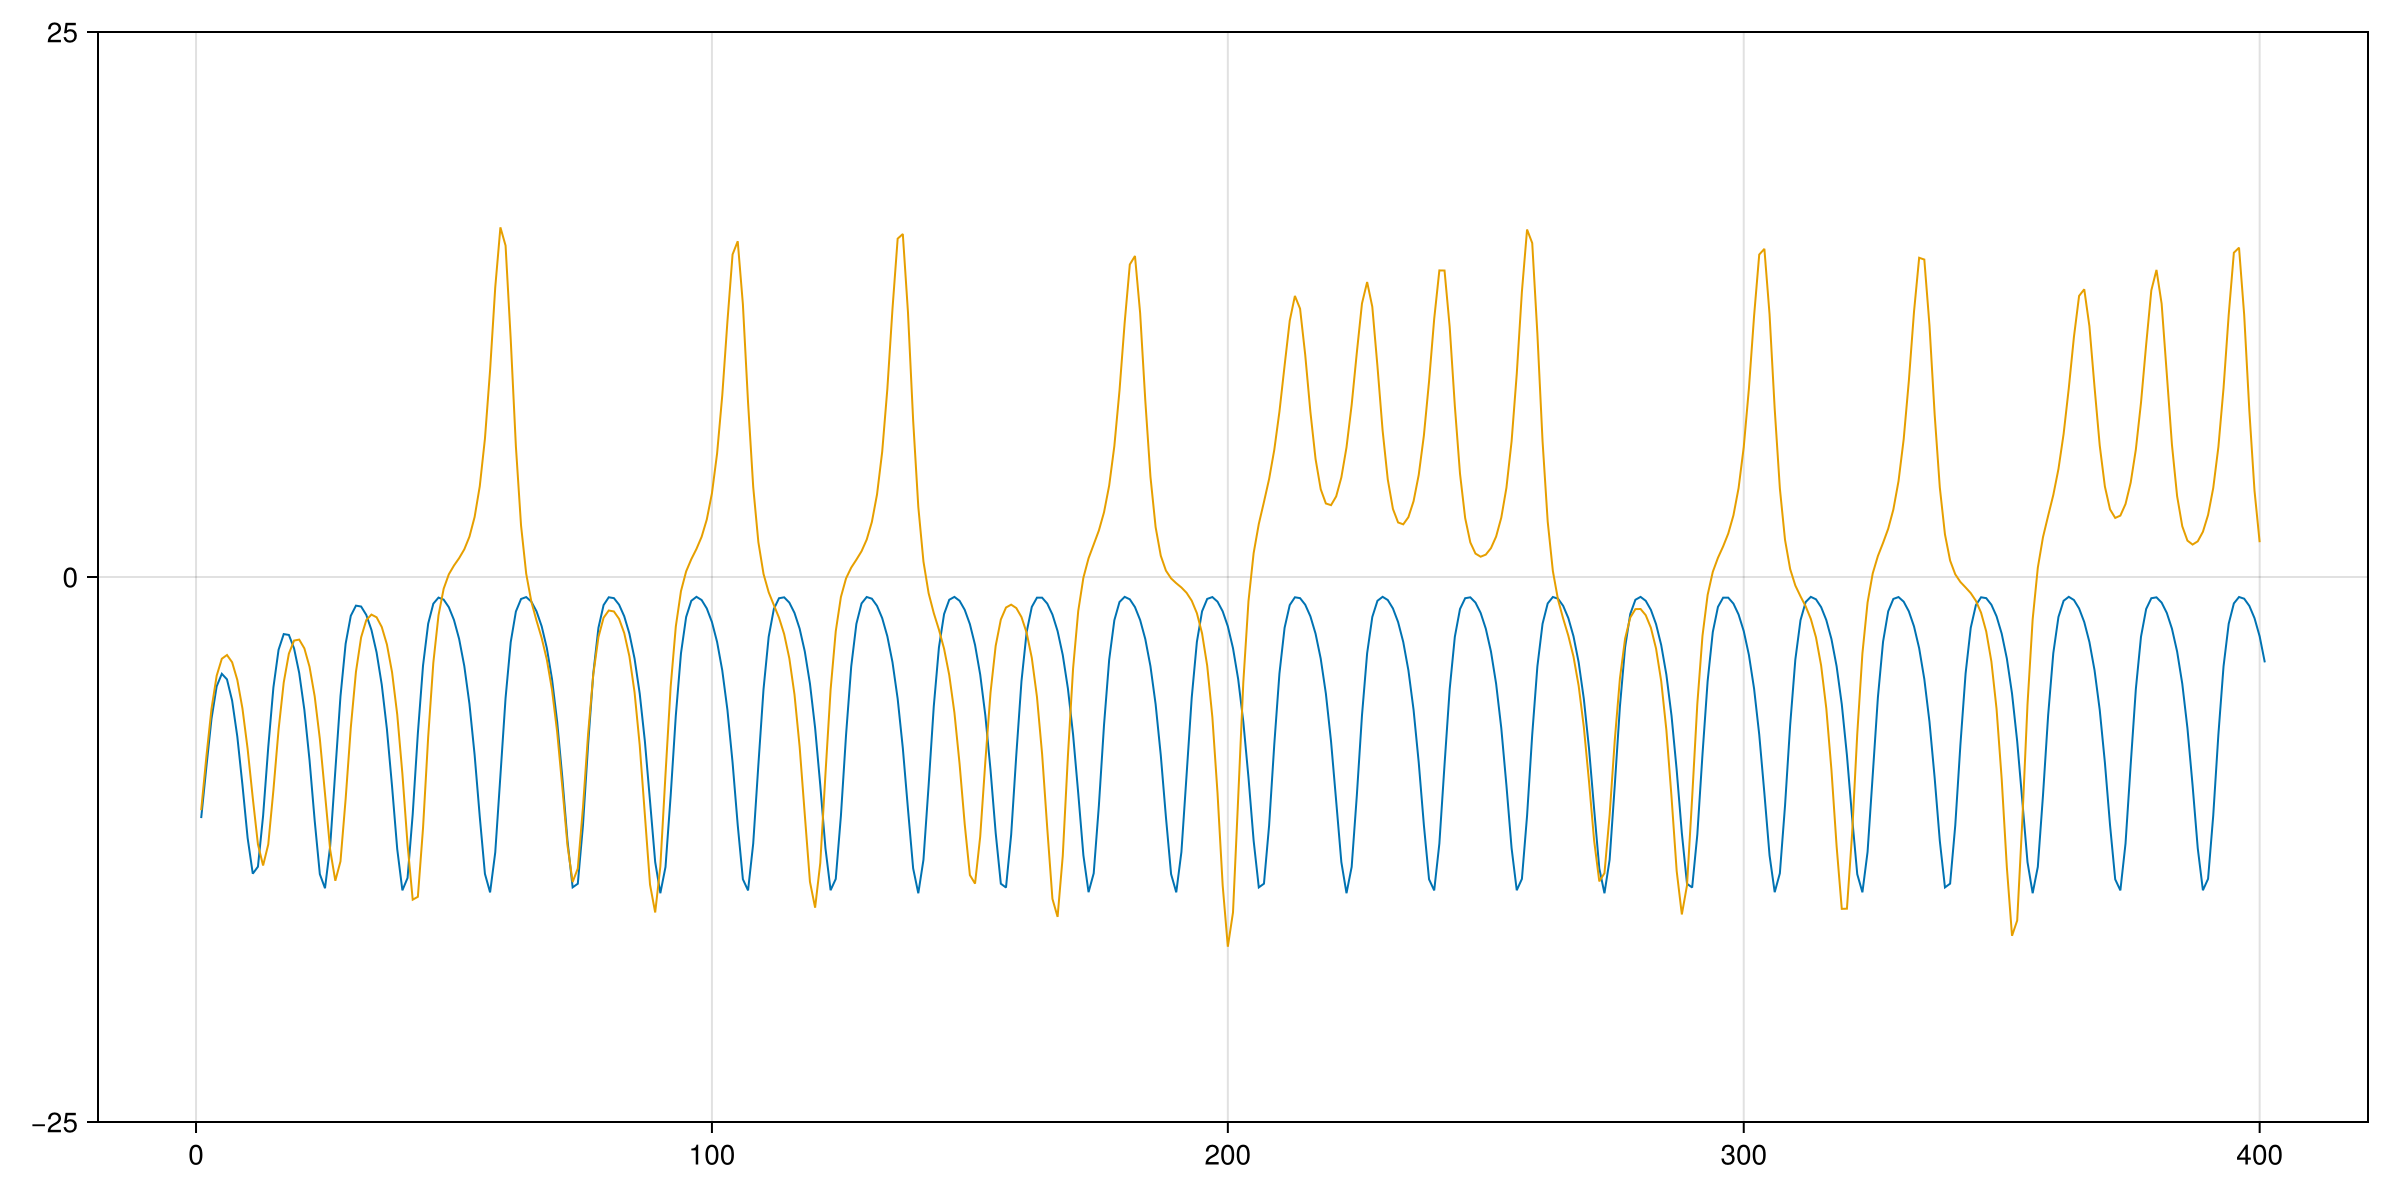

0.24683476571123253


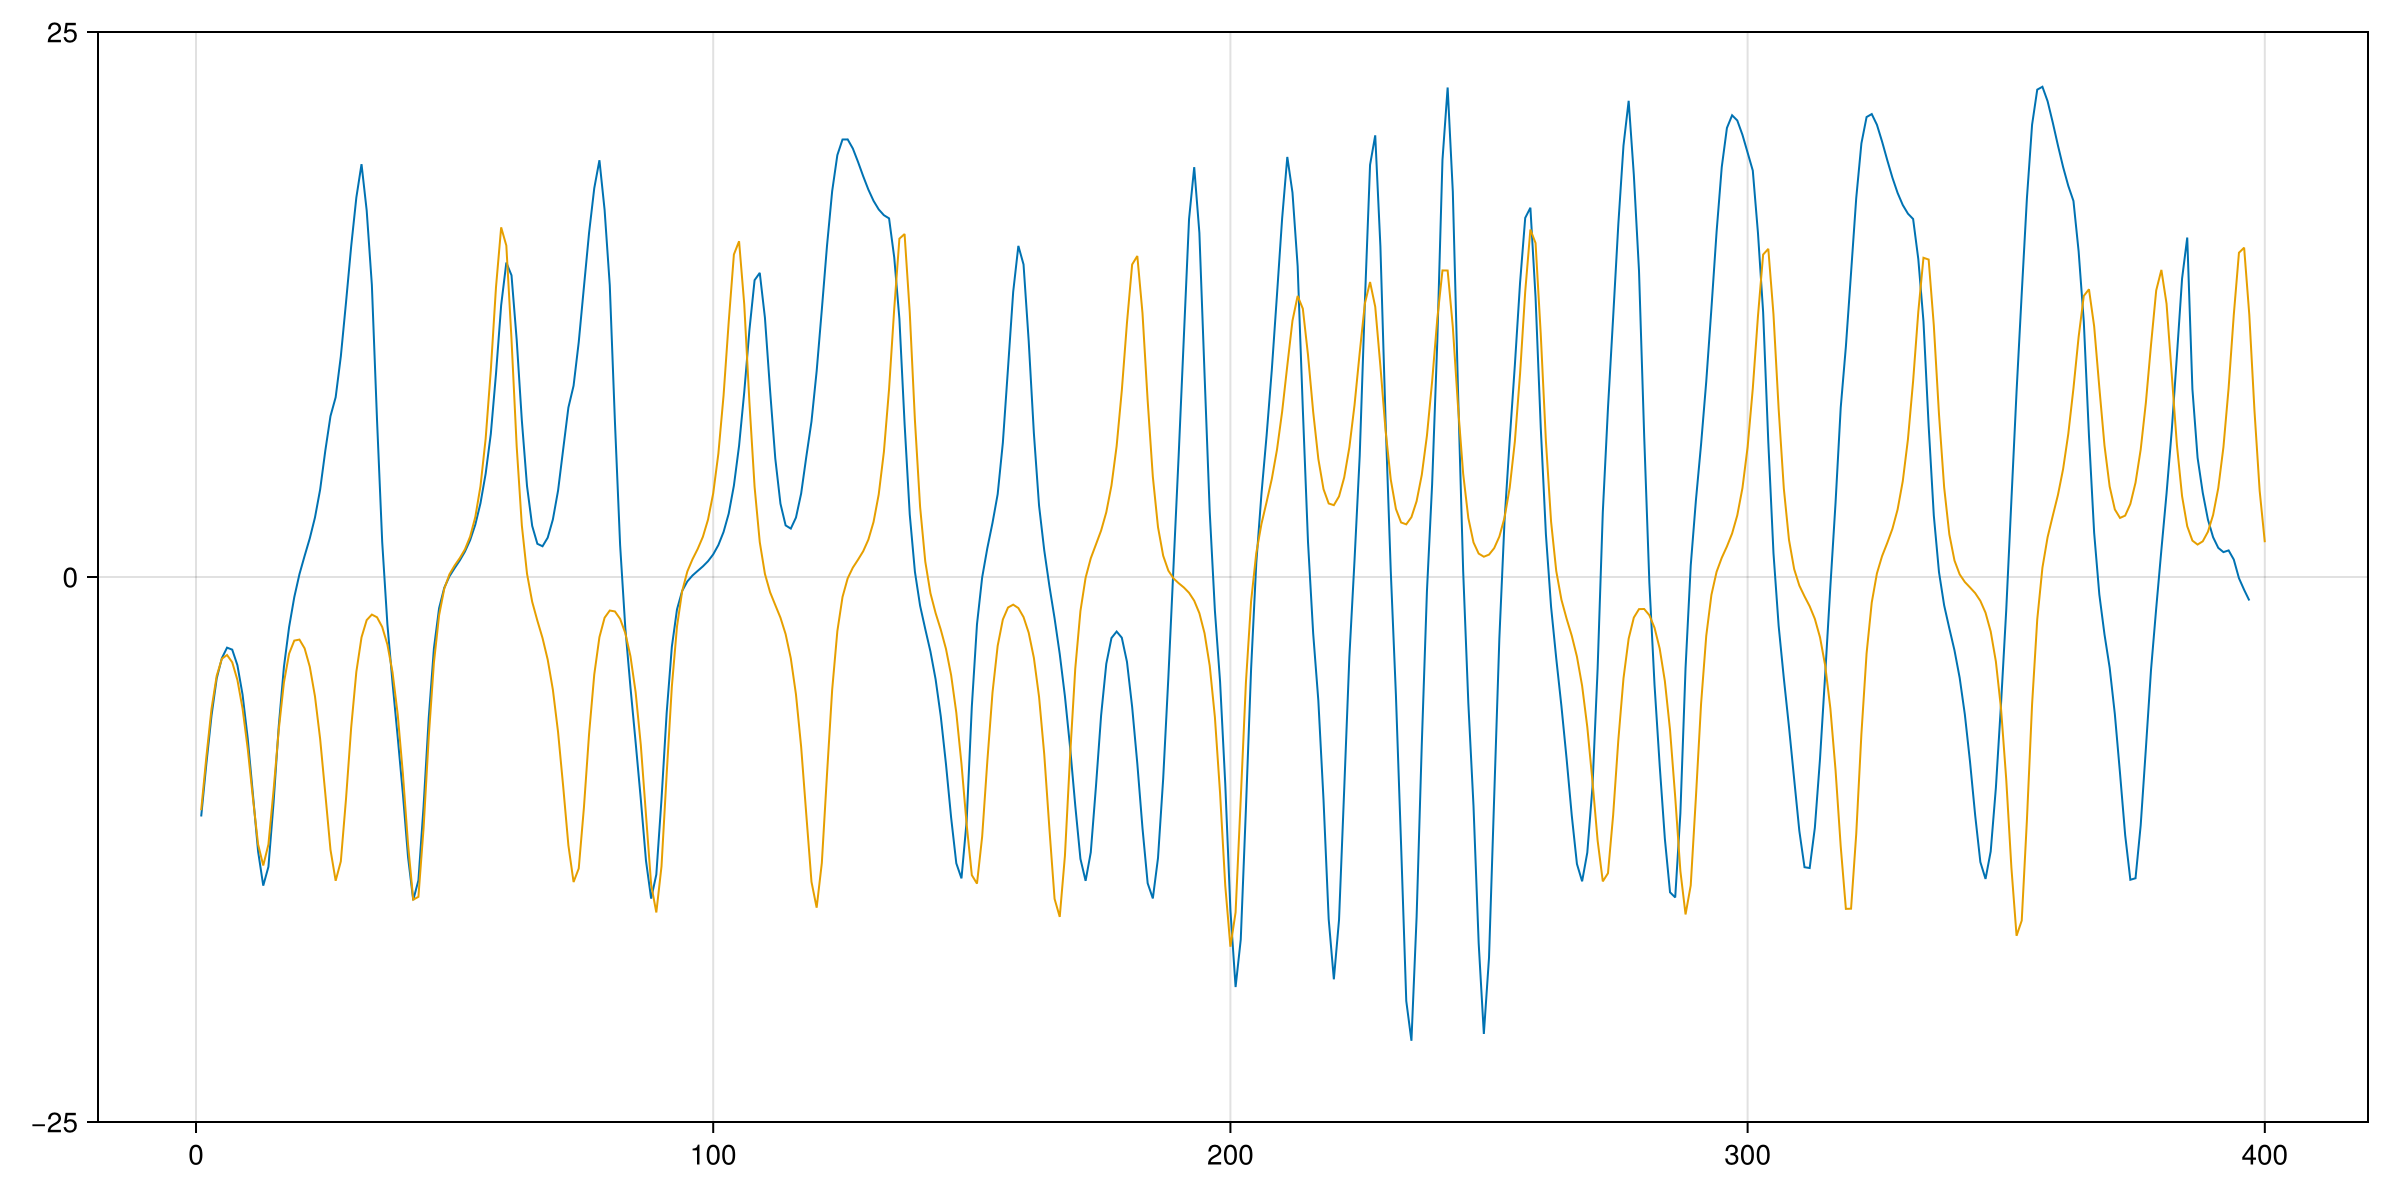

0.18318919632636368


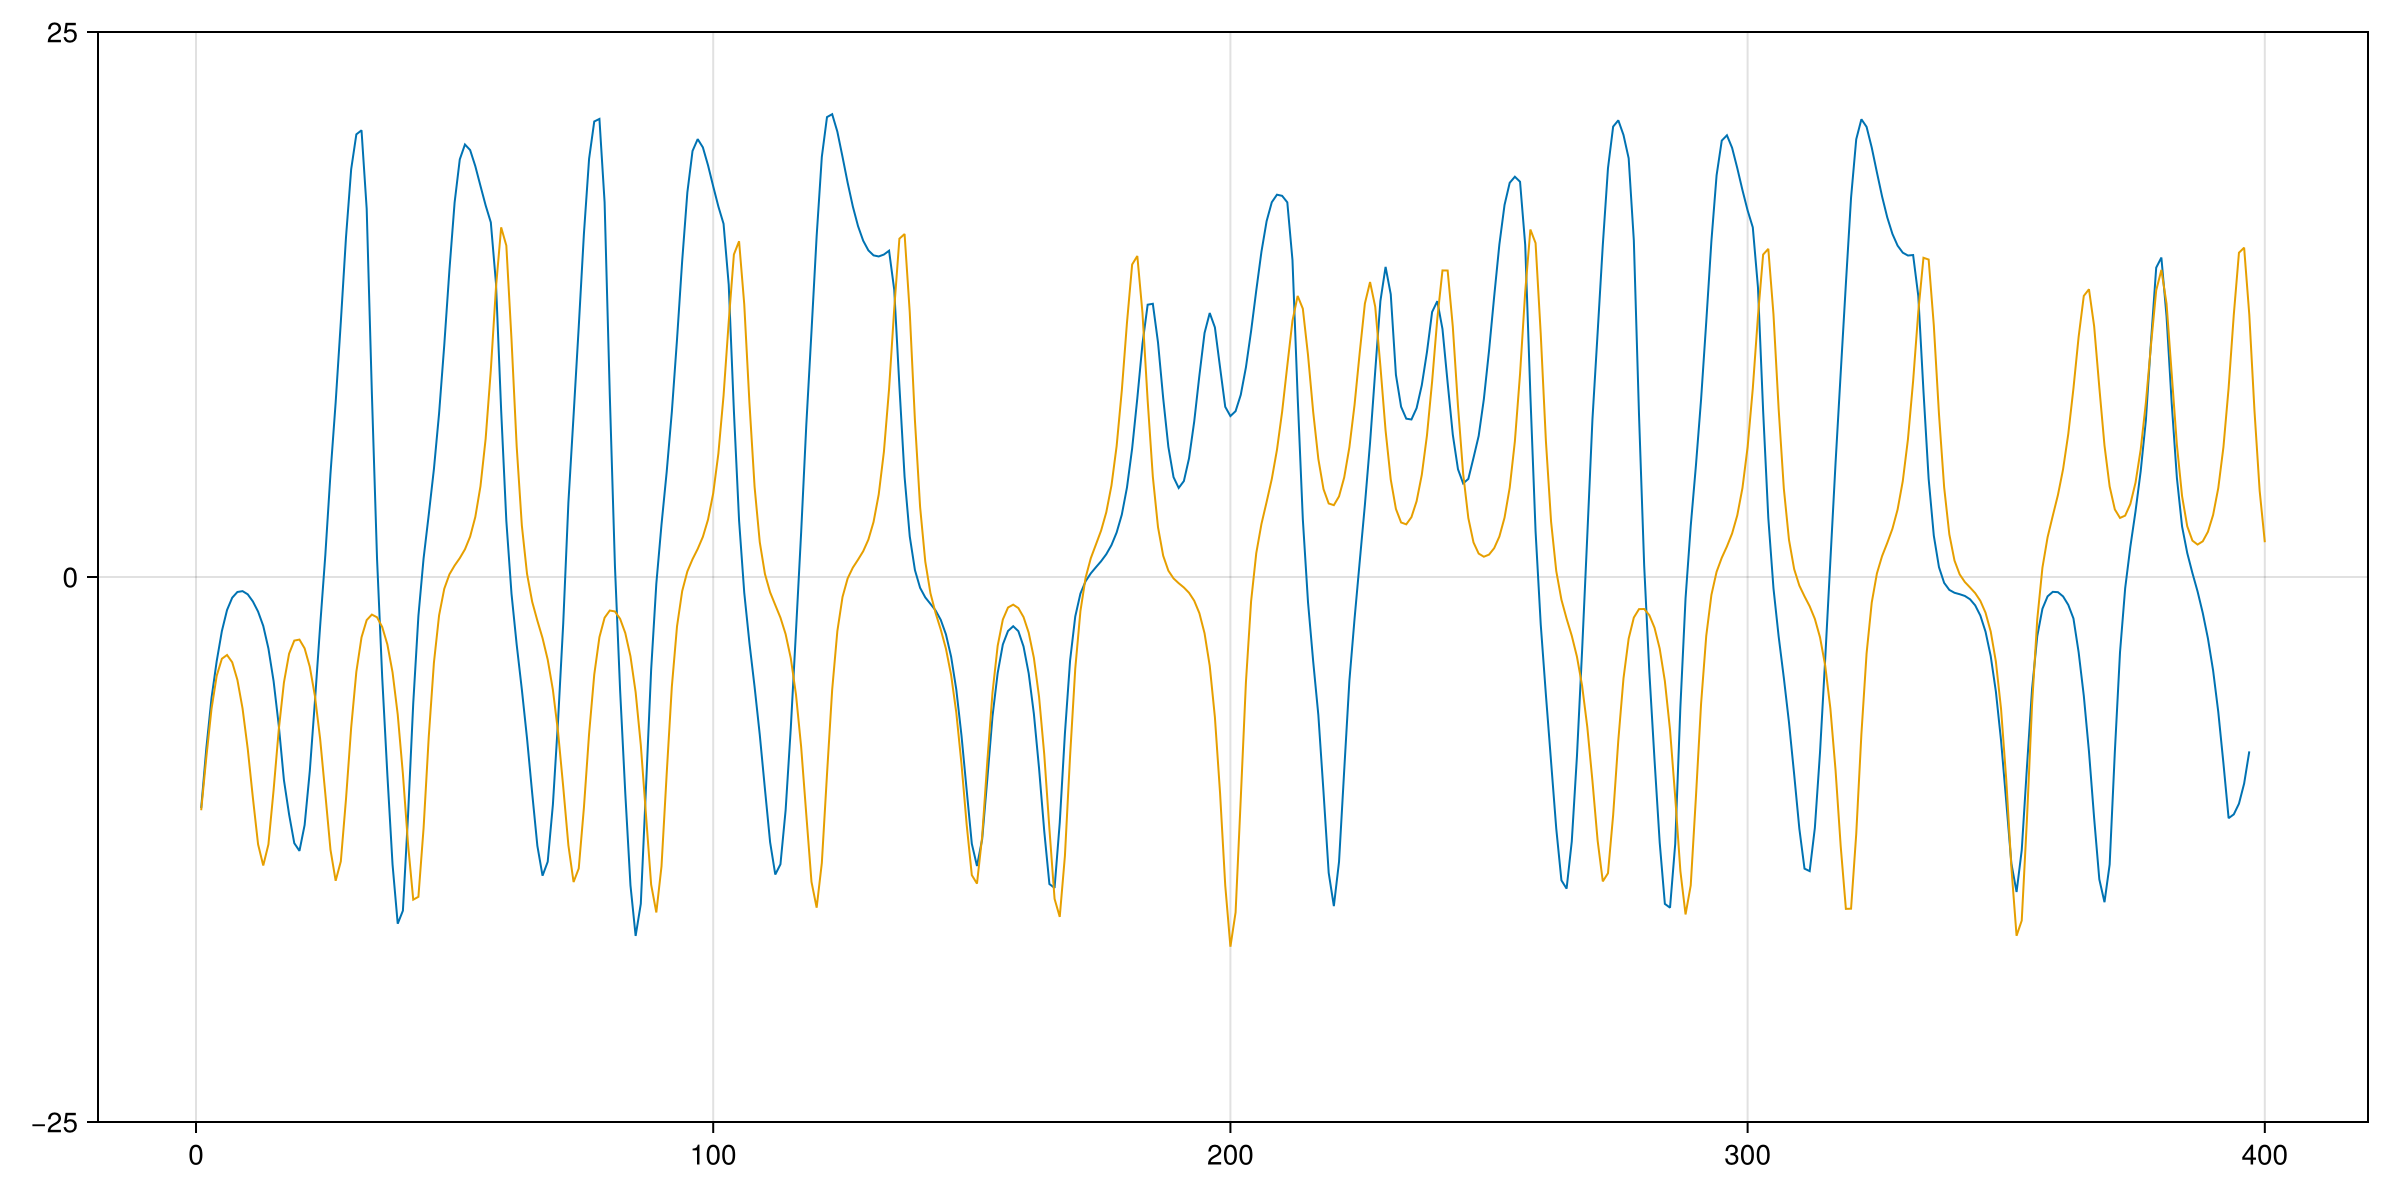

In [40]:
for preds in [vanilla_freerun_preds, switching_freerun_pred, ON_modified_switching_freerun_pred]
    println(cor(preds[1:end-1], lo_test[2:length(preds)]))
    
    fig = Figure( size = (1200,600) )
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    # xlims!(0,300)
    ylims!(-25,25)
    display(fig)
end

Seems to do better with fewer nodes. Has issue with turning points, see worse prediction around each turning point.

In [41]:
function mse(y_true, y_pred)
    return mean((y_true .- y_pred) .^ 2)
end

function trial_parameters(;
        k = 50,
        d = k*0.05,
        ρ = 1.05,
        α = 1.0,
        η = 1/maximum(lo_train),
        β = 0.01,
        m = 3,
        w = 1,
        τ = 1
    )
    ESN_params = create_ESN_params(k, d, ρ, α, η, β)

    states = run_ESN(lo_train, ESN_params)

    # Train regular ol' ESN
    R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

    # Create ordinal partition
    window_size = (m-1)*τ
    part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

    # Train partition based readout
    Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = states)
    # Create transition matrix and modify the partition based readout
    transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
    switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
    ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])



    start_skip = 10

    vanilla_error = mse(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end])
    switching_error = mse(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)])
    ON_modified_switching_error = mse(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)])

    return([vanilla_error, switching_error, ON_modified_switching_error])
end

function plot_results(results, x_values; title="")
    line1 = [result[1] for result in results]
    line2 = [result[2] for result in results]
    line3 = [result[3] for result in results]

    fig = Figure(size = (1000, 600))
    ax = Axis(fig[1, 1])

    lines!(ax, x_values, line1, label = "Vanilla", color = :red)
    lines!(ax, x_values, line2, label = "Switching", color = :blue)
    lines!(ax, x_values, line3, label = "ON Modified Switching", color = :green)

    fig[1, 2] = Legend(fig, ax, title, framevisible = false)

    return(fig)
end

plot_results (generic function with 1 method)

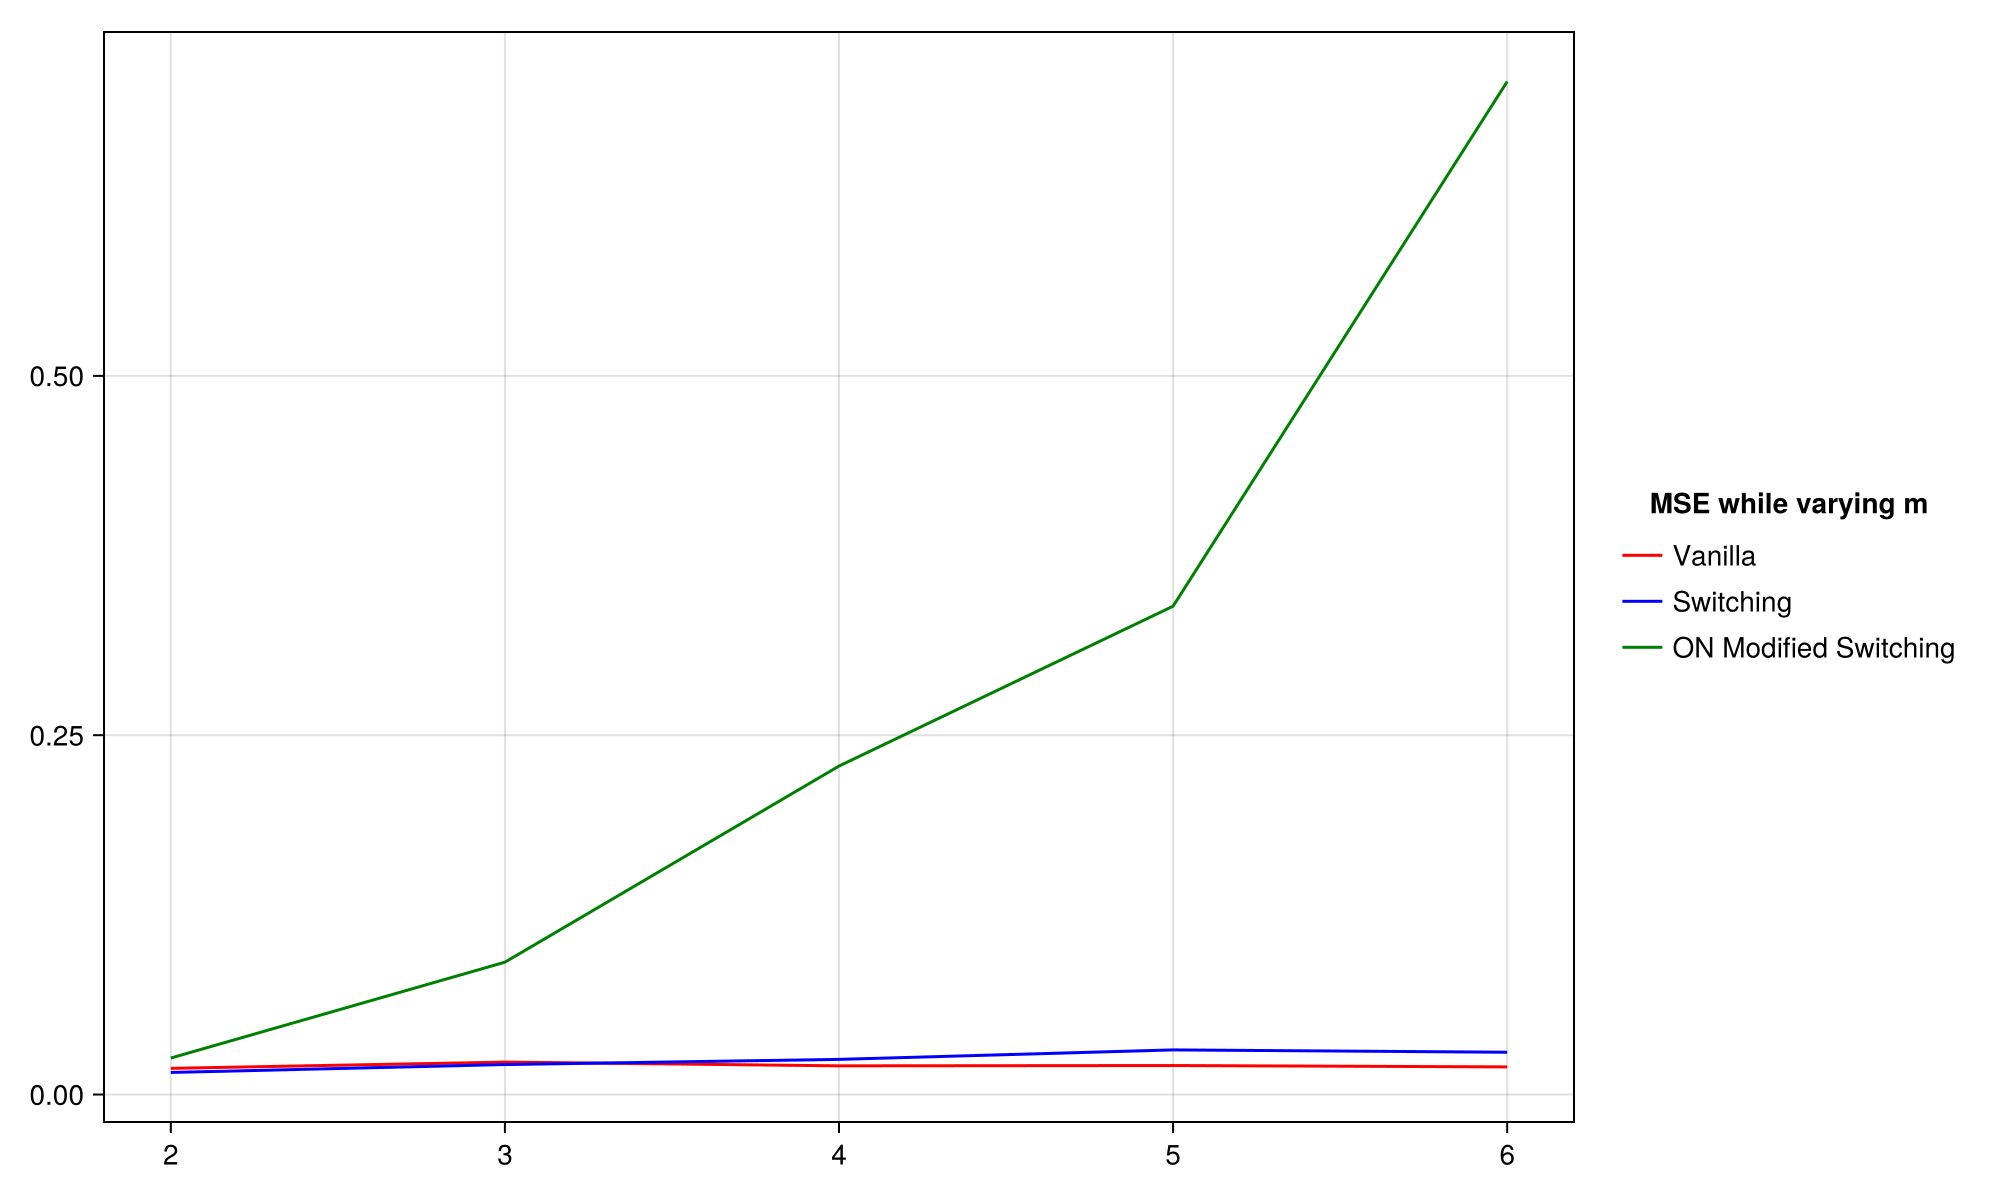

In [46]:
reproduce = 10

plot_results(
    [mean([trial_parameters(m = m) for i in 1:reproduce]) for m in 2:6],
    2:6,
    title="MSE while varying m"
)

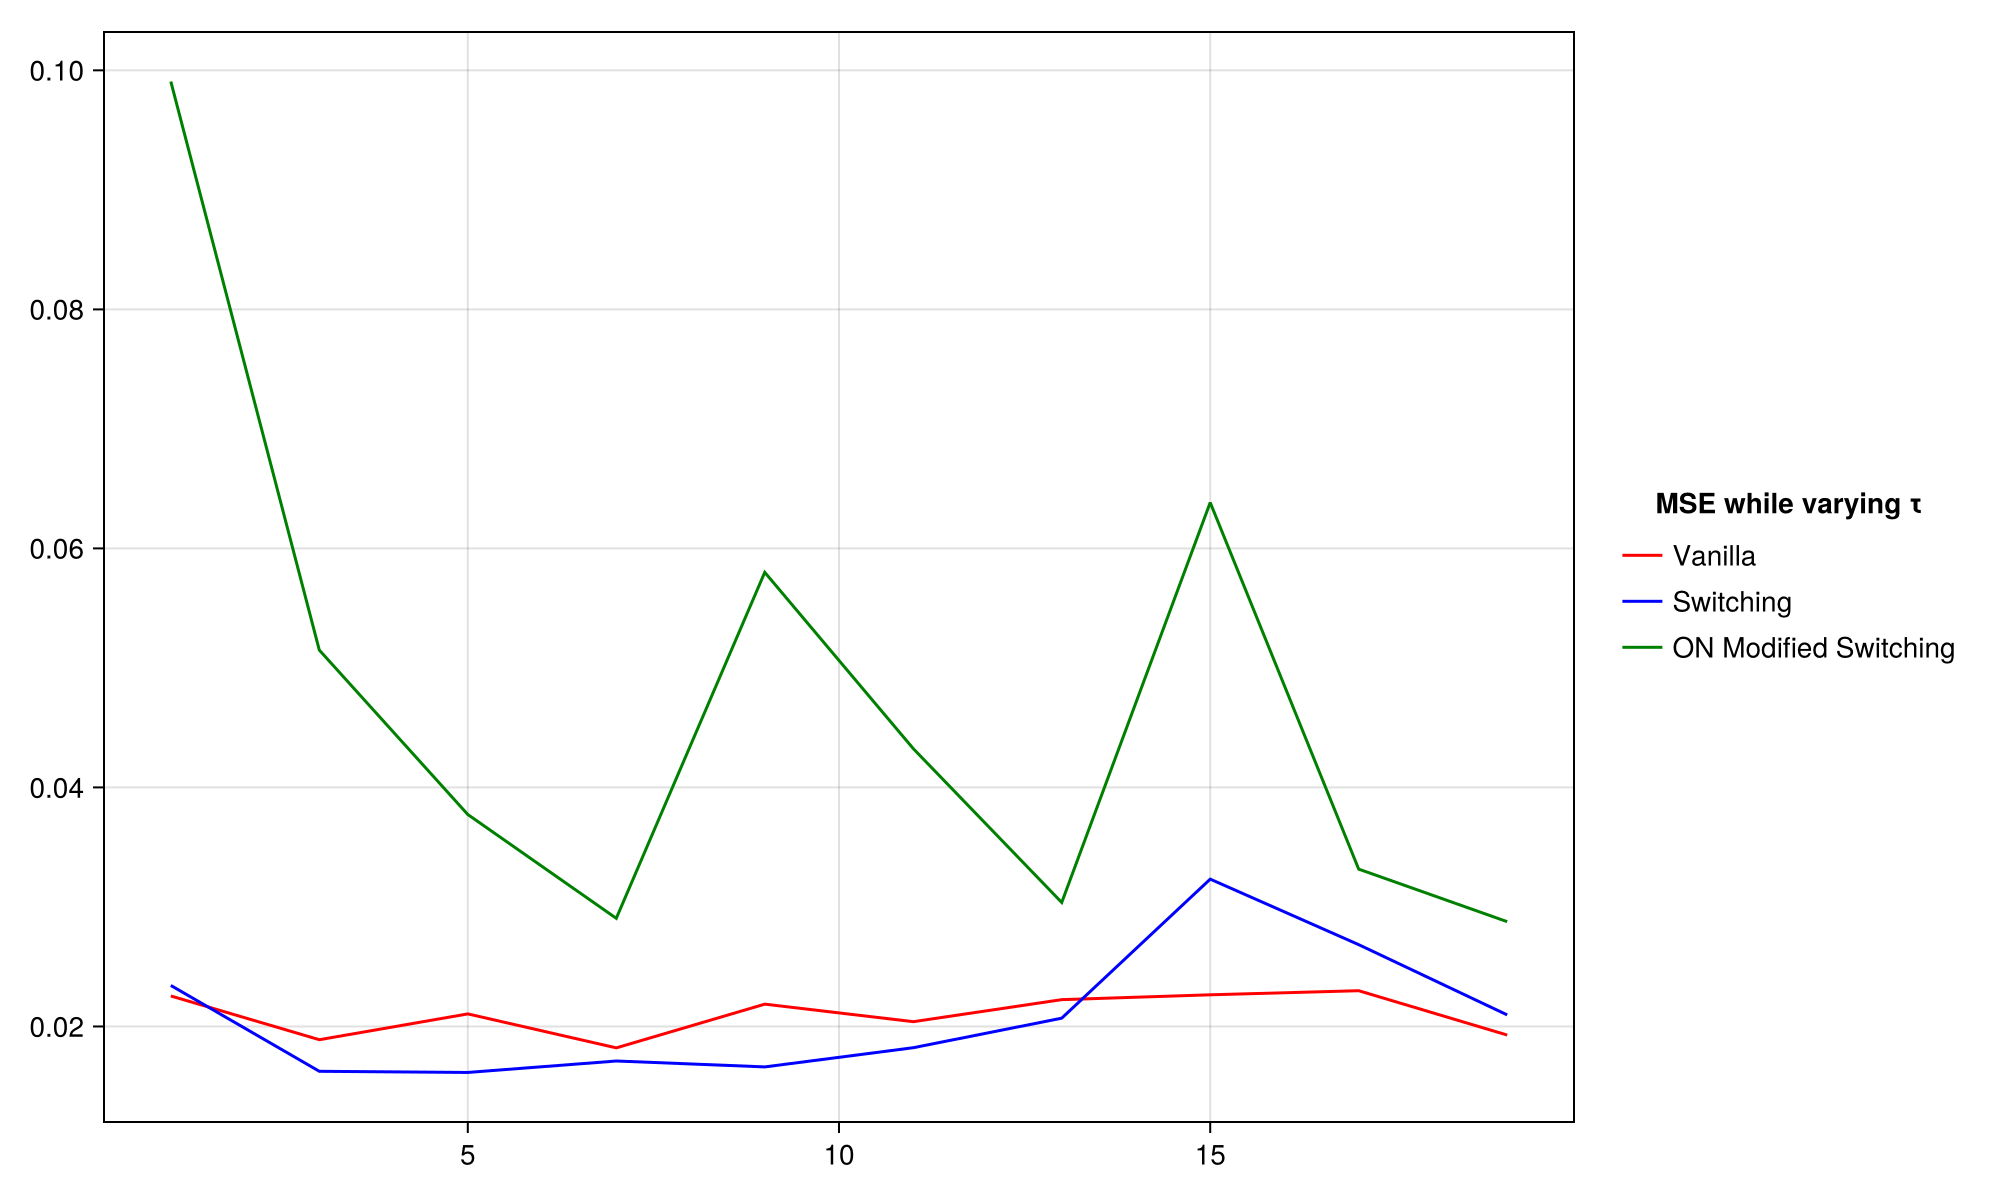

In [47]:
plot_results(
    [mean([trial_parameters(τ = τ) for i in 1:reproduce]) for τ in 1:2:20],
    1:2:20,
    title="MSE while varying τ"
)

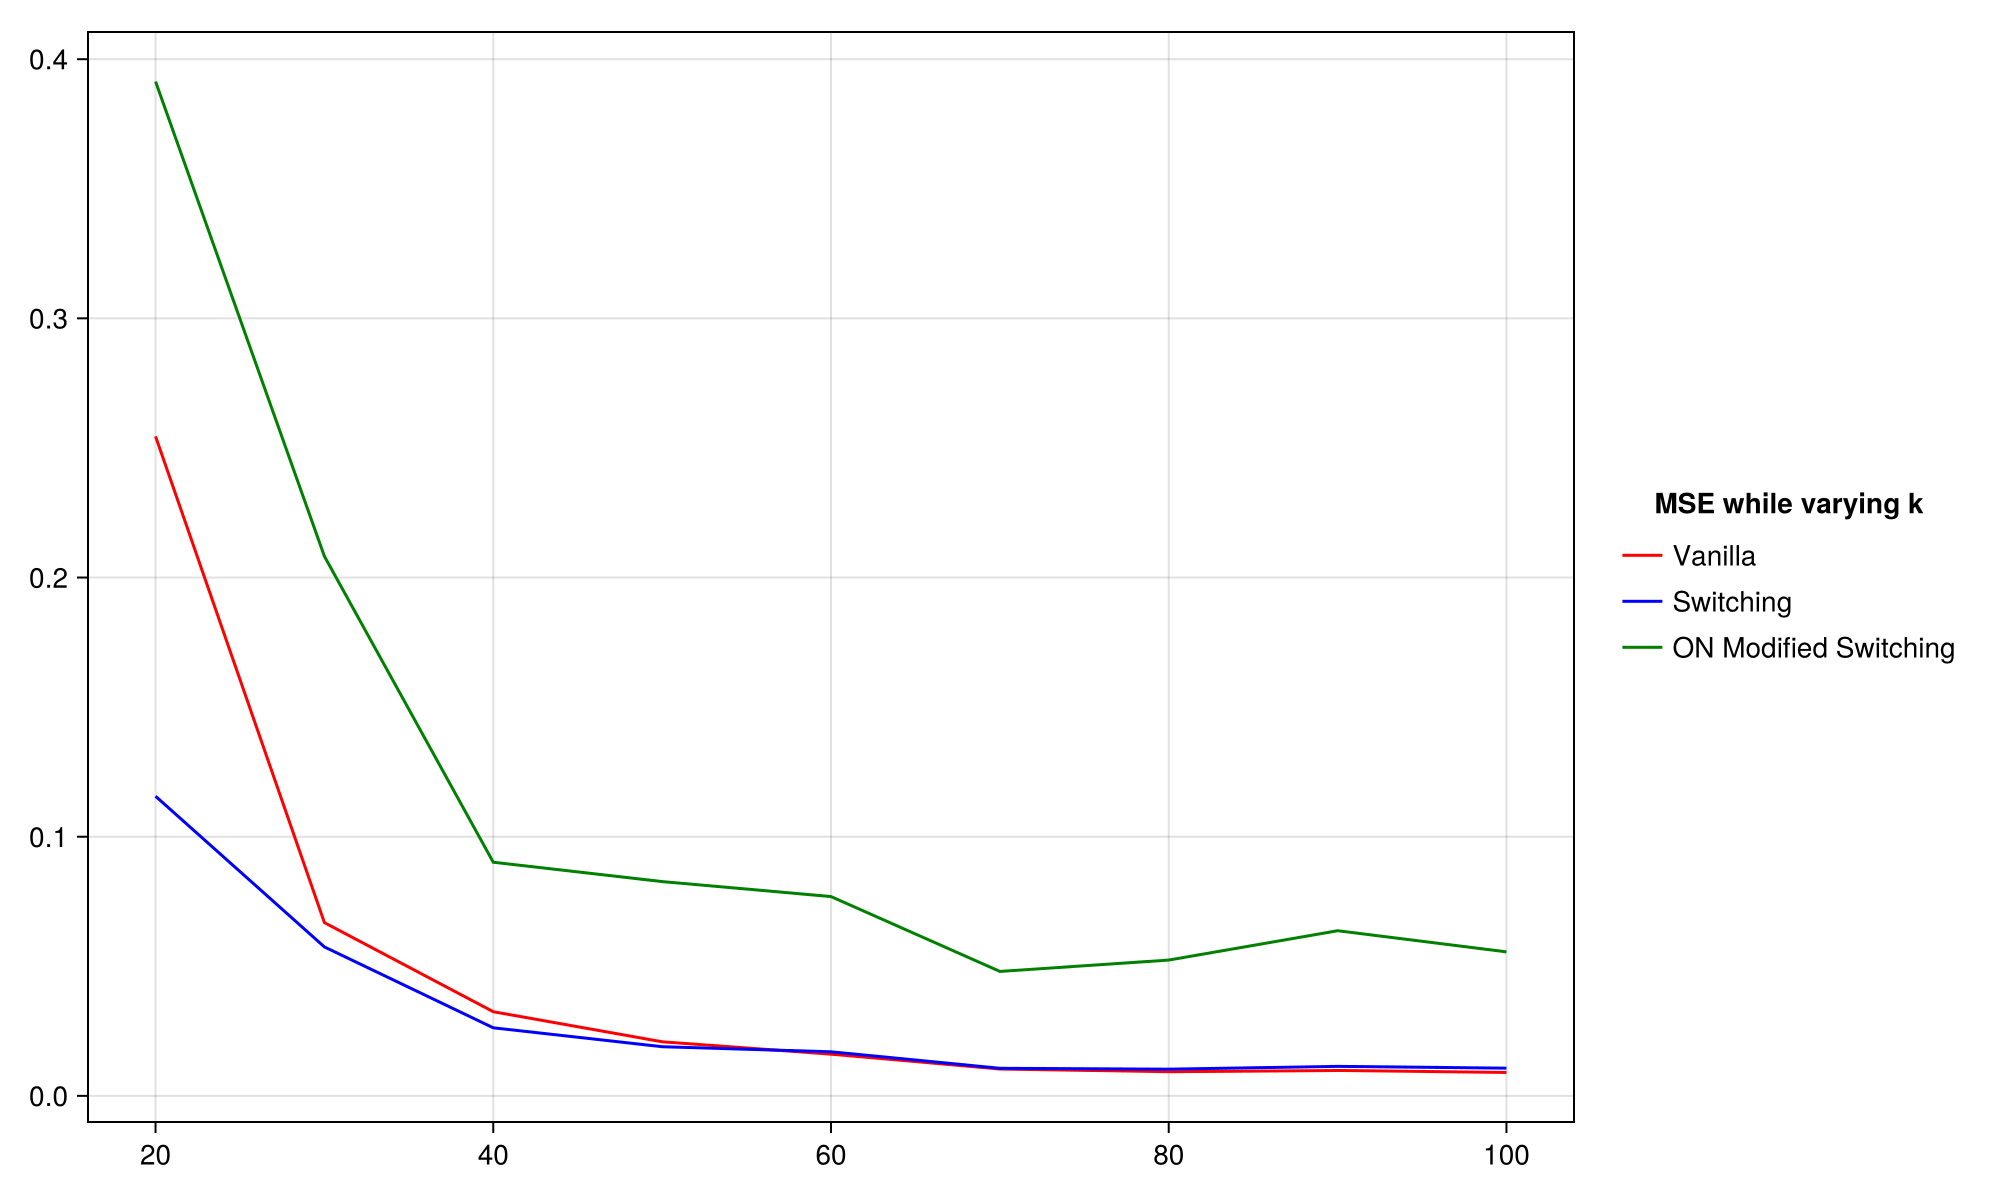

In [48]:
plot_results(
    [mean([trial_parameters(k = k) for i in 1:reproduce]) for k in 20:10:100],
    20:10:100,
    title="MSE while varying k"
)

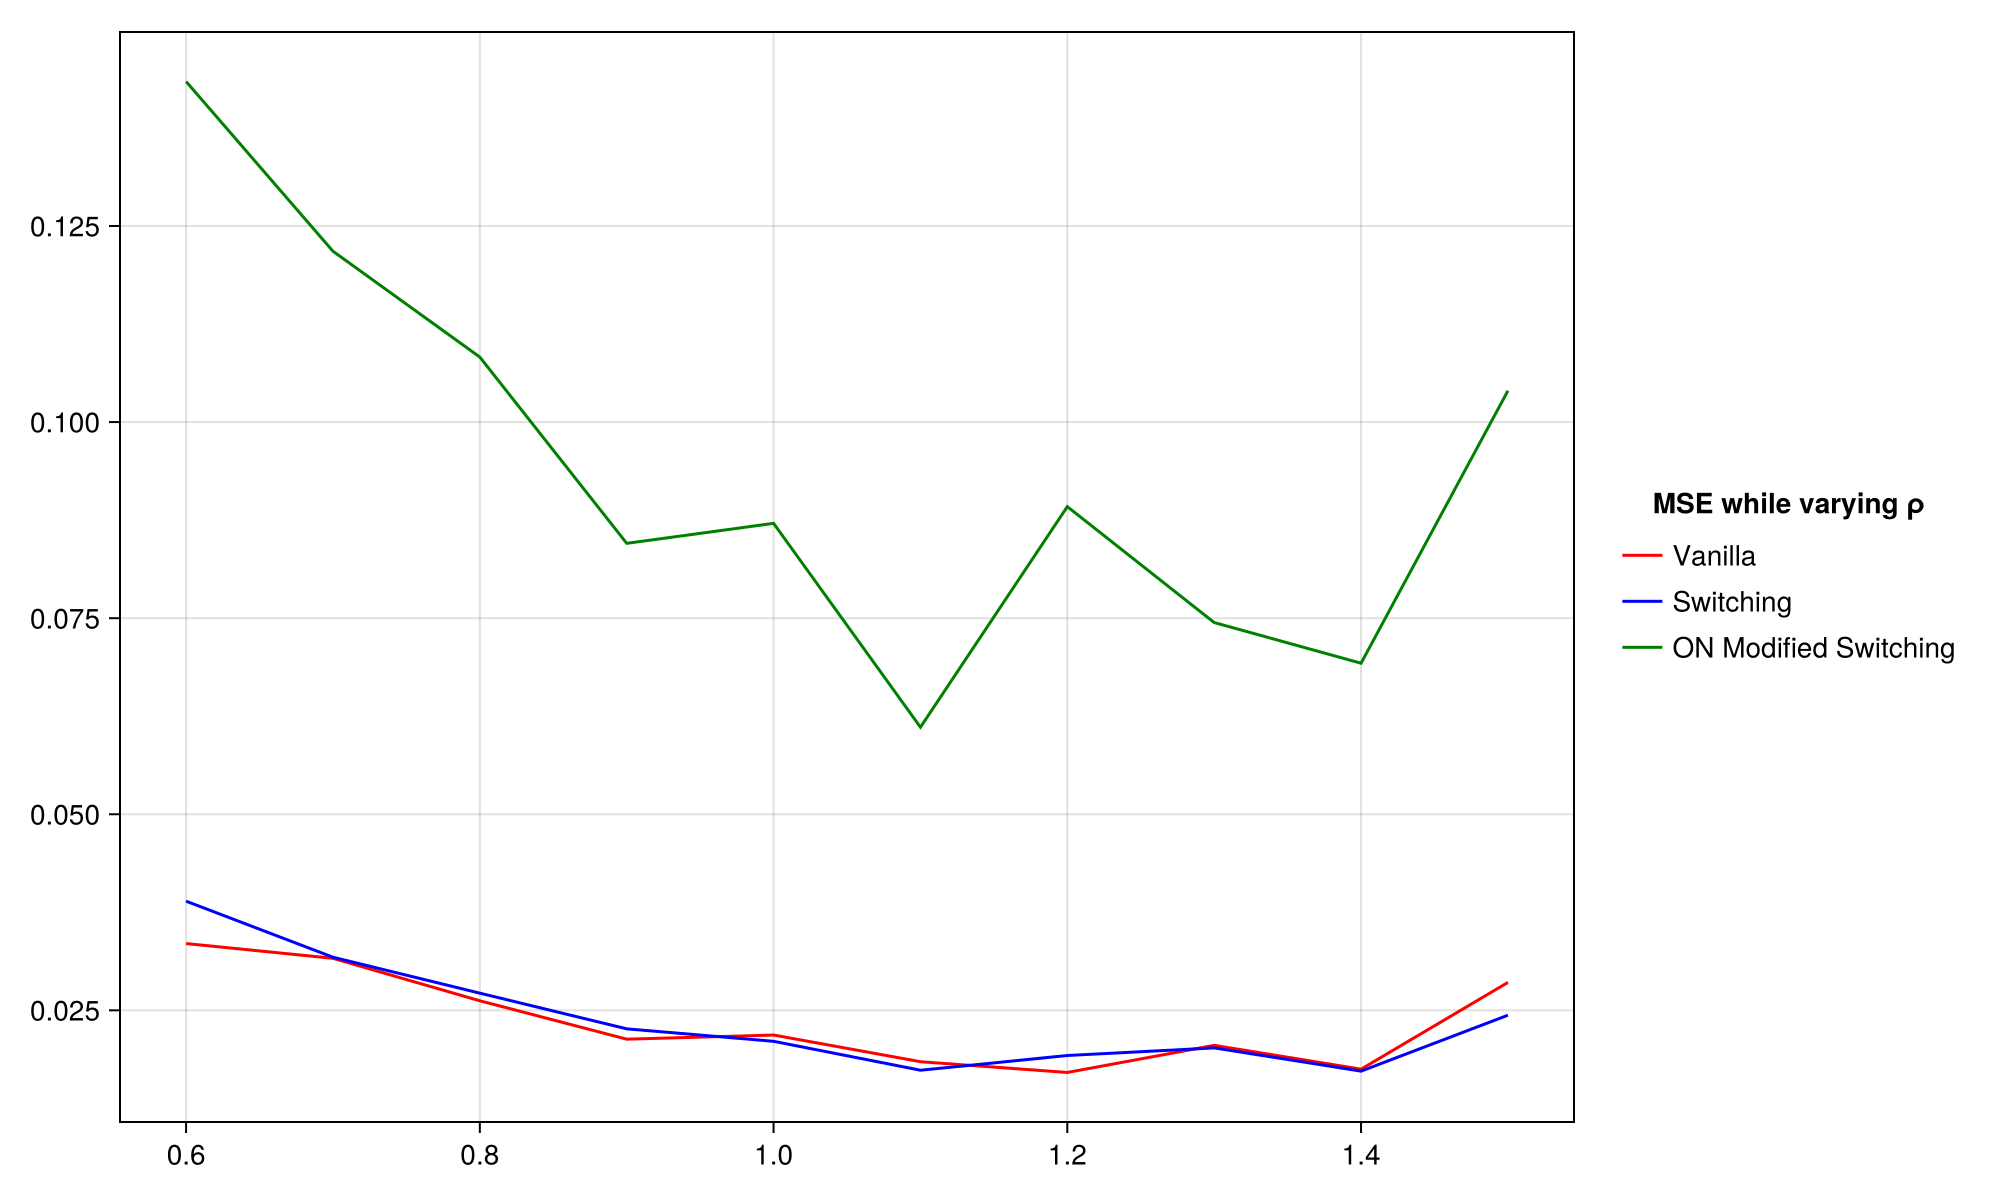

In [49]:
plot_results(
    [mean([trial_parameters(ρ = ρ) for i in 1:reproduce]) for ρ in 0.6:0.1:1.5],
    0.6:0.1:1.5,
    title="MSE while varying ρ"
)

Layered ESN with different reservoir for each ordinal partition. Each reservoir has the same number of nodes and the nodes will map one to one (directed) based on whether the two partitions are connected in the ordinal transition network.

In [ ]:
test_ON_part_adjacency = Dict(
    1 => [2],
    2 => [3],
    3 => [1]
)

k = 40
d = k*0.05
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, m=3, part_connection=0.5, ON_part_adjacency=test_ON_part_adjacency)

In [20]:
function mse(y_true, y_pred)
    return mean((y_true .- y_pred) .^ 2)
end

function trial_parameters_reservoir(;
        k = 50,
        d = k*0.05,
        ρ = 1.05,
        α = 1.0,
        η = 1/maximum(lo_train),
        β = 0.01,
        m = 3,
        w = 1,
        τ = 1
    )
    ESN_params = create_ESN_params(k, d, ρ, α, η, β)

    states = run_ESN(lo_train, ESN_params)

    # Train regular ol' ESN
    R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

    # Create ordinal partition
    window_size = (m-1)*τ
    part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

    # Train partition based readout
    Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = states)
    # Create transition matrix and modify the partition based readout
    transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
    switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
    ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])



    start_skip = 10

    vanilla_error = mse(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end])
    switching_error = mse(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)])
    ON_modified_switching_error = mse(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)])

    return([vanilla_error, switching_error, ON_modified_switching_error])
end

function plot_results(results, x_values; title="")
    line1 = [result[1] for result in results]
    line2 = [result[2] for result in results]
    line3 = [result[3] for result in results]

    fig = Figure(size = (1000, 600))
    ax = Axis(fig[1, 1])

    lines!(ax, x_values, line1, label = "Vanilla", color = :red)
    lines!(ax, x_values, line2, label = "Switching", color = :blue)
    lines!(ax, x_values, line3, label = "ON Modified Switching", color = :green)

    fig[1, 2] = Legend(fig, ax, title, framevisible = false)

    return(fig)
end

plot_results (generic function with 1 method)

In [22]:
reproduce = 5

plot_results(
    [mean([trial_parameters_reservoir(ρ = ρ) for i in 1:reproduce]) for ρ in 0.6:0.1:1.5],
    0.6:0.1:1.5,
    title="MSE while varying ρ"
)

LoadError: UndefVarError: `run_ESN` not defined